# In this notebook ... 
I demonstrate and develop a self organsing map (SOM) for continuous learning.

The SOM is implemented using pytorch, and is drastically accelerated by CUDA computation.
Continuous learning is achieved by retraining the map over regular time intervals.

The training data is assembled in a pandas DataFrame, I have implemented a custom time-aware rolling function that selects a subset of the data, by means of a rolling windows (of say, 1 year width and 1 month step).

For each such window we re-train the map.


# Todo:
- Finish the performance accessment for the map (classification accuracy on the test samples)
- Hyperparameter selection for the SOM
- Test additional datasets


### Notes
- The SOM class is still in this notebook for convinience - as I am still tweaking it. Once development is over it will move out in a .py file.
- *The SOM has been tested, and it works*. For examples look through the current notebook, or open the 'trained_maps' folder and inspect the figures. 
- Each figure (see point above) corresponds to a different time window, and consist of multiple panels. Each panel is a heatmap of the intensity of different words (which means features) over the system neurons. 
- Currently the number of features is low (for testing and debugging). 


In [6]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
import numpy as np

class SOM(nn.Module):
    def __init__(self, input_size, out_size=(10, 10), lr=0.3, sigma=None, weights_0=None):
        '''

        :param input_size:
        :param out_size:
        :param lr:
        :param sigma:
        '''
        super(SOM, self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        # Learning rate parameters
        self.lr = lr
        if sigma is None: self.sigma = max(out_size) / 2
        else:             self.sigma = float(sigma)

        # Initialise weights
        if weights_0 is None: self.weight = nn.Parameter(
                                    torch.randn(input_size, out_size[0] * out_size[1]), 
                                    requires_grad=False)
        else:                 self.weight = nn.Parameter(weights_0, requires_grad=False)
            
        # Register buffers
        self.register_buffer('category', 
            torch.zeros([out_size[0] * out_size[1]], dtype=torch.long) )
        self.register_buffer('unitlosses', 
            torch.ones([out_size[0] * out_size[1]], dtype=torch.double) * input_size )
        
        # Not sure if this needs to be a buffer or a parameter yet, will decide later
        self.locations  = nn.Parameter(torch.Tensor(list(self.get_map_index())), 
                                       requires_grad=False)
        
        # Measure of distance between units and samples
        self.pdist_fn   = nn.PairwiseDistance(p=2)

    def get_map_index(self):
        '''Two-dimensional mapping function'''
        for x in range(self.out_size[0]):
            for y in range(self.out_size[1]):
                yield (x, y)

    def _neighborhood_fn(self, input, current_sigma):
        '''e^(-(input / sigma^2))'''
        input.div_(current_sigma ** 2)
        input.neg_()
        input.exp_()

        return input

    def forward(self, input):
        '''
        Find the location of best matching unit.
        :param input: data
        :return: location of best matching unit, loss
        '''
        
        # Prepare the batch
        batch_size = input.size()[0]
        input = input.view(batch_size, -1, 1)
        batch_weight = self.weight.expand(batch_size, -1, -1)

        # Find best matching unit
        dists = self.pdist_fn(input, batch_weight)
        losses, bmu_indexes = dists.min(dim=1, keepdim=True)
        bmu_locations = self.locations[bmu_indexes]

        return bmu_locations, losses.sum().div_(batch_size).item()
    
    def classify_units(self, input, sample_categories):
                
        batch_size = input.size()[0]
        input = input.view(batch_size, -1, 1)
        batch_weight = self.weight.expand(batch_size, -1, -1)

        dists = self.pdist_fn(input, batch_weight)
        losses, bms_indexes = dists.min(dim=0, keepdim=True)
        losses, bms_indexes = losses[0], bms_indexes[0]  # squeeze
        
        temp = (losses < self.unitlosses)[0]
        
        self.category[temp] = sample_categories[bms_indexes[temp]]
        self.unitlosses[temp] = losses[temp]
              
    def self_organizing(self, input, current_iter, max_iter):
        '''
        Train the Self Oranizing Map(SOM)
        :param input: training data
        :param current_iter: current epoch of total epoch
        :param max_iter: total epoch
        :return: loss (minimum distance)
        '''
        batch_size = input.size()[0]
        
        #Set learning rate and neighbourhood size (linear decay)
        iter_correction = 1.0 - current_iter / max_iter
        lr = self.lr * iter_correction
        sigma = self.sigma * iter_correction

        #Find best matching unit
        bmu_locations, loss = self.forward(input)

        distance_squares = self.locations.float() - bmu_locations.float()
        distance_squares.pow_(2)
        distance_squares = torch.sum(distance_squares, dim=2)

        lr_locations = self._neighborhood_fn(distance_squares, sigma)
        lr_locations.mul_(lr).unsqueeze_(1)

        delta = lr_locations * (input.unsqueeze(2) - self.weight)
        delta = delta.sum(dim=0)
        delta.div_(batch_size)
        self.weight.data.add_(delta)

        return loss
    
    def classify_som(self, data_x, data_y, batchsize):
        '''
        Assigns classes to SOM units, by finding the most similar sample.
        '''
        import numpy as np
        n_chunks = int(data_x.shape[0]/batchsize)

        for chunk_x, chunk_y in zip(data_x.chunk(n_chunks), data_y.chunk(n_chunks)):
            self.classify_units(chunk_x, chunk_y)

    def train_som(self, data, total_epochs, batchsize):

        # Log the quantisation errors over training
        losses = list() 

        # Train the map
        for epoch in range(total_epochs):

            # Counting the batches
            n_batch = 0

            # Iterating over the batches
            while (n_batch+1) * batchsize < data.shape[0]:

                running_loss = 0

                loss = self.self_organizing(data[n_batch*batchsize:(n_batch+1)*batchsize],
                                           epoch, total_epochs)   
                running_loss += loss

                losses.append(running_loss)
                n_batch += 1

        return self.weight, losses
    
    def predict_class(self, data_x):
        
        # Prepare the batch
        batch_size = input.size()[0]
        input = input.view(batch_size, -1, 1)
        batch_weight = self.weight.expand(batch_size, -1, -1)

        # Find best matching unit
        dists = self.pdist_fn(input, batch_weight)
        losses, bmu_indexes = dists.min(dim=1, keepdim=True) 
        
        # Predict class
        y_pred = sample_categories[bmu_indexes]
        
        return y_pred
    

ImportError: cannot import name 'PILLOW_VERSION' from 'PIL' (C:\Anaconda3\lib\site-packages\PIL\__init__.py)

In [7]:
pip install pillow<7


Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.


# Load data, convert to tensors, encode categories

In [ ]:

import pandas as pd

# Load data and convert to tensors
###############################################################################################
train_path = 'processed_data/train_cleaned_data.csv'
test_path = 'processed_data/test_cleaned_data.csv'
feature_name_path = 'processed_data/keywords_cleaned_data.txt'
time_col = 'TIME'
target_col = 'TARGET'
###############################################################################################

# Load data
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
train[time_col] = pd.to_datetime(train[time_col])
test[time_col] = pd.to_datetime(test[time_col])

# Load feature names, make the a list
feature_names = pd.read_csv(feature_name_path)
feature_names = feature_names.values.T.tolist()[0]

# Encode target names as integers
cat2int = {f:i for i,f in enumerate(train[target_col].unique())}

# Normalise samples
train[feature_names] = train[feature_names].div(train[feature_names].sum(axis=1), axis=0)
test[feature_names] = test[feature_names].div(test[feature_names].sum(axis=1), axis=0)

# Convert to tensors
# X
Xtnsr_train = torch.tensor(train[feature_names].values)
Xtnsr_test = torch.tensor(test[feature_names].values)
# Y
Ytnsr_train = torch.tensor(train[target_col].replace(cat2int).values)
#Ytnsr_test = torch.tensor(test[target_col].replace(cat2int).values)


In [2]:
train['TARGET'].hist()

NameError: name 'train' is not defined

In [4]:
train.shape

(49978, 253)

### We have sample imbalance

# Encoded categories

In [5]:
cat2int

{'PARENTS': 0,
 'TECH': 1,
 'QUEER VOICES': 2,
 'POLITICS': 3,
 'BLACK VOICES': 4,
 'ENTERTAINMENT': 5,
 'CRIME': 6,
 'WEDDINGS': 7,
 'PARENTING': 8,
 'STYLE & BEAUTY': 9,
 'THE WORLDPOST': 10,
 'WELLNESS': 11,
 'COLLEGE': 12,
 'SPORTS': 13,
 'BUSINESS': 14,
 'HOME & LIVING': 15,
 'COMEDY': 16,
 'TRAVEL': 17,
 'FOOD & DRINK': 18,
 'WORLD NEWS': 19,
 'IMPACT': 20,
 'MONEY': 21,
 'WEIRD NEWS': 22,
 'FIFTY': 23,
 'LATINO VOICES': 24,
 'HEALTHY LIVING': 25,
 'DIVORCE': 26,
 'WORLDPOST': 27,
 'RELIGION': 28,
 'TASTE': 29,
 'EDUCATION': 30,
 'MEDIA': 31,
 'WOMEN': 32,
 'GOOD NEWS': 33,
 'ARTS & CULTURE': 34,
 'STYLE': 35,
 'GREEN': 36,
 'ARTS': 37,
 'CULTURE & ARTS': 38,
 'SCIENCE': 39,
 'ENVIRONMENT': 40}

# Train a map, test functionality

In [6]:

# Train a map over the entire dataset
###############################################################################################
subsampling_rate = 1  # To make things faster for debugging. 
total_epochs = 10  # linear decay to learning rate and radius.
batchsize = 100  # reduces the amount of GPU ram needed.
map_side = 15
###############################################################################################

# Determine whether a GPU is available to pytorch (for efficient compuation)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialise an SOM
som = SOM(input_size=Xtnsr_train[0].shape[0], out_size=(map_side,map_side))

# Send assets to GPU (there should be enough RAM for small datasets, otherwise I need to chunk it)
som = som.to(device)
Xgpu = Xtnsr_train[::subsampling_rate].to(device)  # subsample and move data to device
Ygpu = Ytnsr_train[::subsampling_rate].to(device)

# Train som
som.train_som(data=Xgpu, total_epochs=total_epochs, batchsize=batchsize)

pass # To supress jupyter from printing the output


### Check whether the map is working fine by inspecting the intensity of features over different units

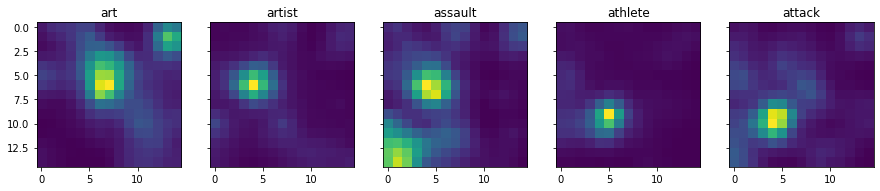

In [7]:
import matplotlib.pyplot as plt

fig,axarr = plt.subplots(1, 5, figsize=(15,5), sharey=True)
for n, name in enumerate(feature_names[10:15]):
    axarr[n].imshow(som.weight[n,:].reshape([map_side,map_side]).cpu())
    axarr[n].set_title(name)
    

In [12]:

trump_idx = np.where(np.array(feature_names) == 'trump')[0][0]
clinton_idx = np.where(np.array(feature_names) == 'clinton')[0][0]
obama_idx = np.where(np.array(feature_names) == 'obama')[0][0]
president_idx = np.where(np.array(feature_names) == 'president')[0][0]

print('ID of keyword trump:  '+str(trump_idx))
print('ID of keyword clinton:  '+str(clinton_idx))
print('ID of keyword obama:  '+str(obama_idx))
print('ID of keyword president:  '+str(president_idx))


ID of keyword trump:  230
ID of keyword clinton:  49
ID of keyword obama:  155
ID of keyword president:  173


In [13]:
import matplotlib.pyplot as plt

fig,axarr = plt.subplots(1, 4, figsize=(15,5), sharey=True)
for n, name in enumerate([clinton_idx, obama_idx, trump_idx, president_idx]):
    axarr[n].imshow(som.weight[n,:].reshape([map_side,map_side]).cpu())
    axarr[n].set_title(feature_names[name])
    

### Everything is in order - the trained map is smooth and appears to be fine. 

# Train a sequence of maps

In [14]:

def custom_timeaware_roll(df, lookback, freq, func, verbose):
    """
    Applies a custom function over a pd.DataFrame time-aware rolling window.
    The output of the custom function may be anything, it does not matter.
    This is in contrast to .rolling().apply() - which resquires that the output of the function is a real number.

    All outputs are stored in a list and returned to the user.

    Input:
    - Index should be pandas Timestamp.
    - lookback is the window size, should be pd.Timedelta
    - freq is the window step, should be pd.Timedelta
    - func is a function applied over the rolling window

    Returns:
    1 - a list with timestamps corresponding to the *end time* of each timewindow.
    2 - a list of all the outputs of func over the rolling windows.

    """
    import numpy as np
    
    t_start = df.index[0]
    t_end = df.index[-1]
    n_max = (t_end - t_start - 1 * lookback) / freq
    n_max = np.ceil(n_max).astype(int)

    # Store the endtime of all windows
    A = [t_start + lookback + freq * n for n in range(n_max)]

    # Iterate over the rolling window and store the results of func
    B = []
    for n in range(n_max):
        a = t_start + freq * n
        b = t_start + lookback + freq * n
        if verbose: print('Window # ' + str(n) + ' spanning from ' + str(a) + ' to ' + str(b))

        B += [func(df[a: b])]

    return A, B


In [15]:

def my_wrapper(data, store_in, som, total_epochs, batchsize, feature_names, subsampling_rate):
    
    """
    This wrapper is designed to work with the custom time aware roll funciton.
    It does 3 things:
    - Trains a map given some data (these data correspond to specific window)
    - Strucutres the weights of the trained map in a dataframe according to the project's standards.
    - Stores the map results in csv format, under a unique name based on the time of the data
    Executes map training"""
    import numpy as np
        
    # Determine if GPU is available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Subsample and move data to device
    Xtnsr = torch.tensor(data[feature_names].values)
    Xgpu = Xtnsr[::subsampling_rate].to(device)  
    print('Training with '+str(Xgpu.shape[0])+' samples.')
    
    # Train map
    weights, losses = som.train_som(data=Xgpu,
                                total_epochs=total_epochs, 
                                batchsize=batchsize)
    
    # Create a dataframe, according to the project's convections
    df_map = pd.DataFrame(som.weight.cpu().numpy().T, columns=feature_names)
    df_map.index.name = 'UNIT_ID'
    df_map.insert(0, 'I', som.locations.cpu().numpy()[:,0])    # The row of each unit
    df_map.insert(1, 'J', som.locations.cpu().numpy()[:,1])    # The col of each unit
    df_map.insert(2, 'TARGET', np.nan * np.ones(len(df_map)))  # The target assigned to that unit
    df_map.insert(3, 'Q_ERROR', np.nan * np.ones(len(df_map))) # The mean quantisation error assosciated with that uni
    df_map.insert(4, 'N_HITS', np.nan * np.ones(len(df_map)))  # The number of samples assigned to that unit
    
    # Move to storage
    df_map.to_csv(store_in+'testing_'+data.index.min().strftime('%Y-%m-%d')
                          +'_to_'+data.index.max().strftime('%Y-%m-%d')+'.csv')
    
    return losses


In [17]:


# Train a map over the entire dataset
###############################################################################################
subsampling_rate = 1  # To make things faster for debugging. 
total_epochs = 10  # linear decay to learning rate and radius.
batchsize = 500  # reduces the amount of GPU ram needed.
map_side = 15
###############################################################################################

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

som = SOM(input_size=len(feature_names), out_size=(map_side,map_side))
som = som.to(device)


losses = custom_timeaware_roll(df=train.set_index('TIME').sort_index(), 
                               lookback=pd.Timedelta('365days') , 
                               freq=pd.Timedelta('365days')/4,  
                               func = lambda x: my_wrapper(x, 
                                                           store_in='trained_maps/', 
                                                           som=som, 
                                                           feature_names=feature_names,
                                                           subsampling_rate=subsampling_rate,
                                                           total_epochs=total_epochs, 
                                                           batchsize=batchsize), 
                               verbose=True)


Window # 0 spanning from 2012-01-28 00:00:00 to 2013-01-27 00:00:00
Training with 10050 samples.
Window # 1 spanning from 2012-04-28 06:00:00 to 2013-04-28 06:00:00
Training with 10084 samples.
Window # 2 spanning from 2012-07-28 12:00:00 to 2013-07-28 12:00:00
Training with 10015 samples.
Window # 3 spanning from 2012-10-27 18:00:00 to 2013-10-27 18:00:00
Training with 9950 samples.
Window # 4 spanning from 2013-01-27 00:00:00 to 2014-01-27 00:00:00
Training with 9881 samples.
Window # 5 spanning from 2013-04-28 06:00:00 to 2014-04-28 06:00:00
Training with 9272 samples.
Window # 6 spanning from 2013-07-28 12:00:00 to 2014-07-28 12:00:00
Training with 7802 samples.
Window # 7 spanning from 2013-10-27 18:00:00 to 2014-10-27 18:00:00
Training with 6475 samples.
Window # 8 spanning from 2014-01-27 00:00:00 to 2015-01-27 00:00:00
Training with 5543 samples.
Window # 9 spanning from 2014-04-28 06:00:00 to 2015-04-28 06:00:00
Training with 4911 samples.
Window # 10 spanning from 2014-07-28 

# Did all the maps train properly? 
We will check if all maps achieved a low loss.

In [18]:
[plt.plot(l) for l in losses[1][1:]]
#plt.yscale('log')

[[<matplotlib.lines.Line2D at 0x26bbe13d8d0>],

# We can see that all maps followed a similar trajectory in terms of losses.

This means that no time window included a significantly different dataset. 
If that was the case, we would have see spiking in losses.

# Produce some images

In [19]:

def feature_intensity_plotter(som, feature_id, feature_names, output_path,
                              dpi=100, logscale=True, shape=None):
    
    from matplotlib.colors import LogNorm, Normalize
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import numpy as np
    from collections.abc import Iterable

    # Get SOM strucutre
    map_width  = int(som['J'].max() + 1)
    map_height = int(som['I'].max() + 1)  # +1 because it is an index
    n_features = len(feature_names)

    # Transform to array
    arr = np.zeros((map_height, map_width, n_features)) * np.nan
    arr[som['I'].values.astype(int), som['J'].values.astype(int), :] = som[feature_names].values

    # Plotting
    maxval  = np.max(arr[:, :, :])
    minval  = np.min(arr[:, :, :])
    minval  = 0.0001
    unitlen = 3
    normer  = (LogNorm if logscale else Normalize)
    if isinstance(feature_id, Iterable):
        N   = len(feature_id)
        
        if shape is None:
            Nsq = int(np.ceil(np.sqrt(N))) 
            Nsq1 = Nsq2 = Nsq
        else:
            Nsq1,Nsq2 = shape
        fig, axarr = plt.subplots(Nsq1, Nsq2, figsize=(Nsq2 * unitlen, Nsq1 * unitlen))
        axvec = axarr.flatten()
        for i, fid in enumerate(feature_id):
            arr[:, :, fid][arr[:, :, fid] < minval] = minval
            axvec[i].imshow(arr[:, :, fid],
                            cmap='plasma',
                            #    vmin=0, vmax=maxval,
                            norm=normer(vmin=minval, vmax=maxval))
            axvec[i].set_title(feature_names[fid])
            axvec[i].axis('off')
    else:
        plt.imshow(arr[:, :, feature_id],
                   cmap='plasma',
                   # vmin=0, vmax=maxval,
                   norm=normer(vmin=minval, vmax=maxval))
        plt.axis('off')

        # Save of display plots
    if output_path is None:
        plt.show()
    else:
        plt.savefig(output_path, dpi=dpi)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


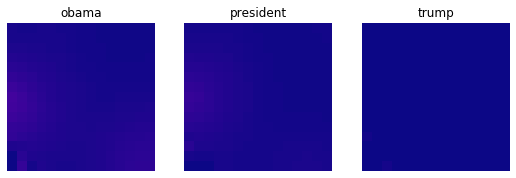

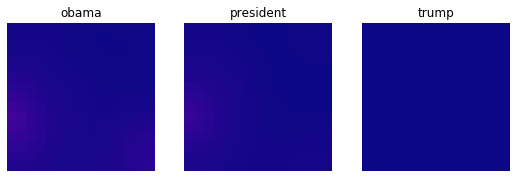

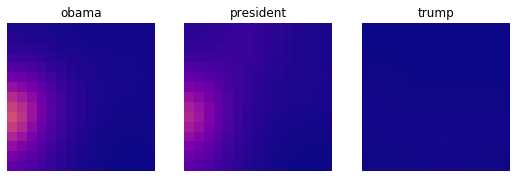

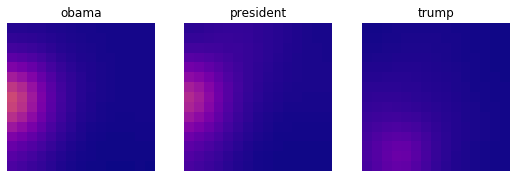

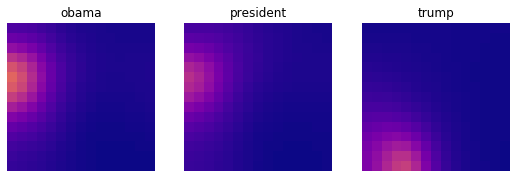

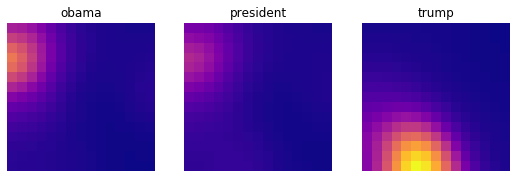

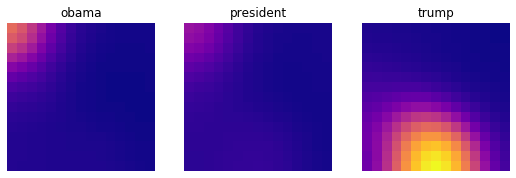

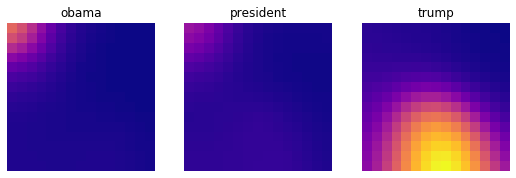

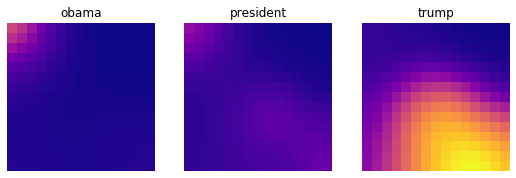

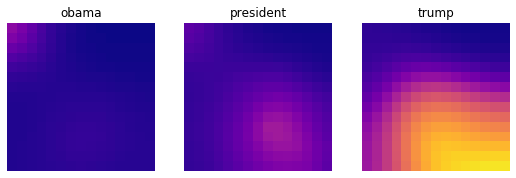

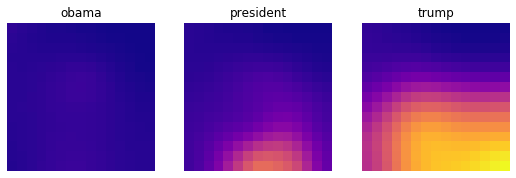

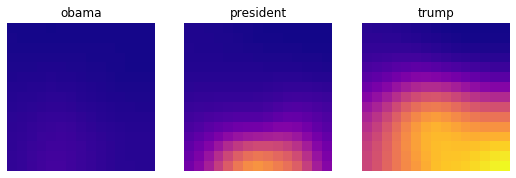

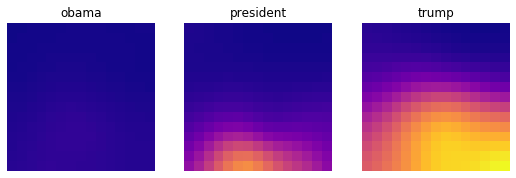

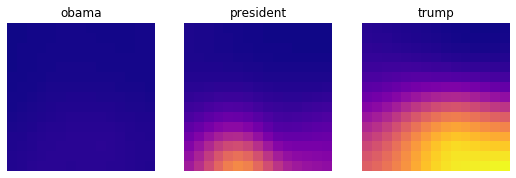

In [22]:



import os 


#############################################################################
maps_path = 'trained_maps/'
visualistions_output = 'trained_maps/'
feature_idx_to_plot = [obama_idx, president_idx, trump_idx]
#############################################################################

# Find all maps (identify that by checking the file format)
map_fns = [f for f in os.listdir(maps_path) if f.split('.')[-1] == 'csv']

# Iterate over all files, create visualisations
for map_fn in map_fns:
    df_som = pd.read_csv(maps_path+map_fn, index_col='UNIT_ID')

    image_fn = visualistions_output + 'heatmap_for_' + map_fn.split('.')[0] + '.png'

    feature_intensity_plotter(som=df_som, feature_id=feature_idx_to_plot, 
                              feature_names=feature_names,
                              output_path=image_fn,
                              dpi=100, logscale=False,
                              shape = (1,3))

    

KeyboardInterrupt: 

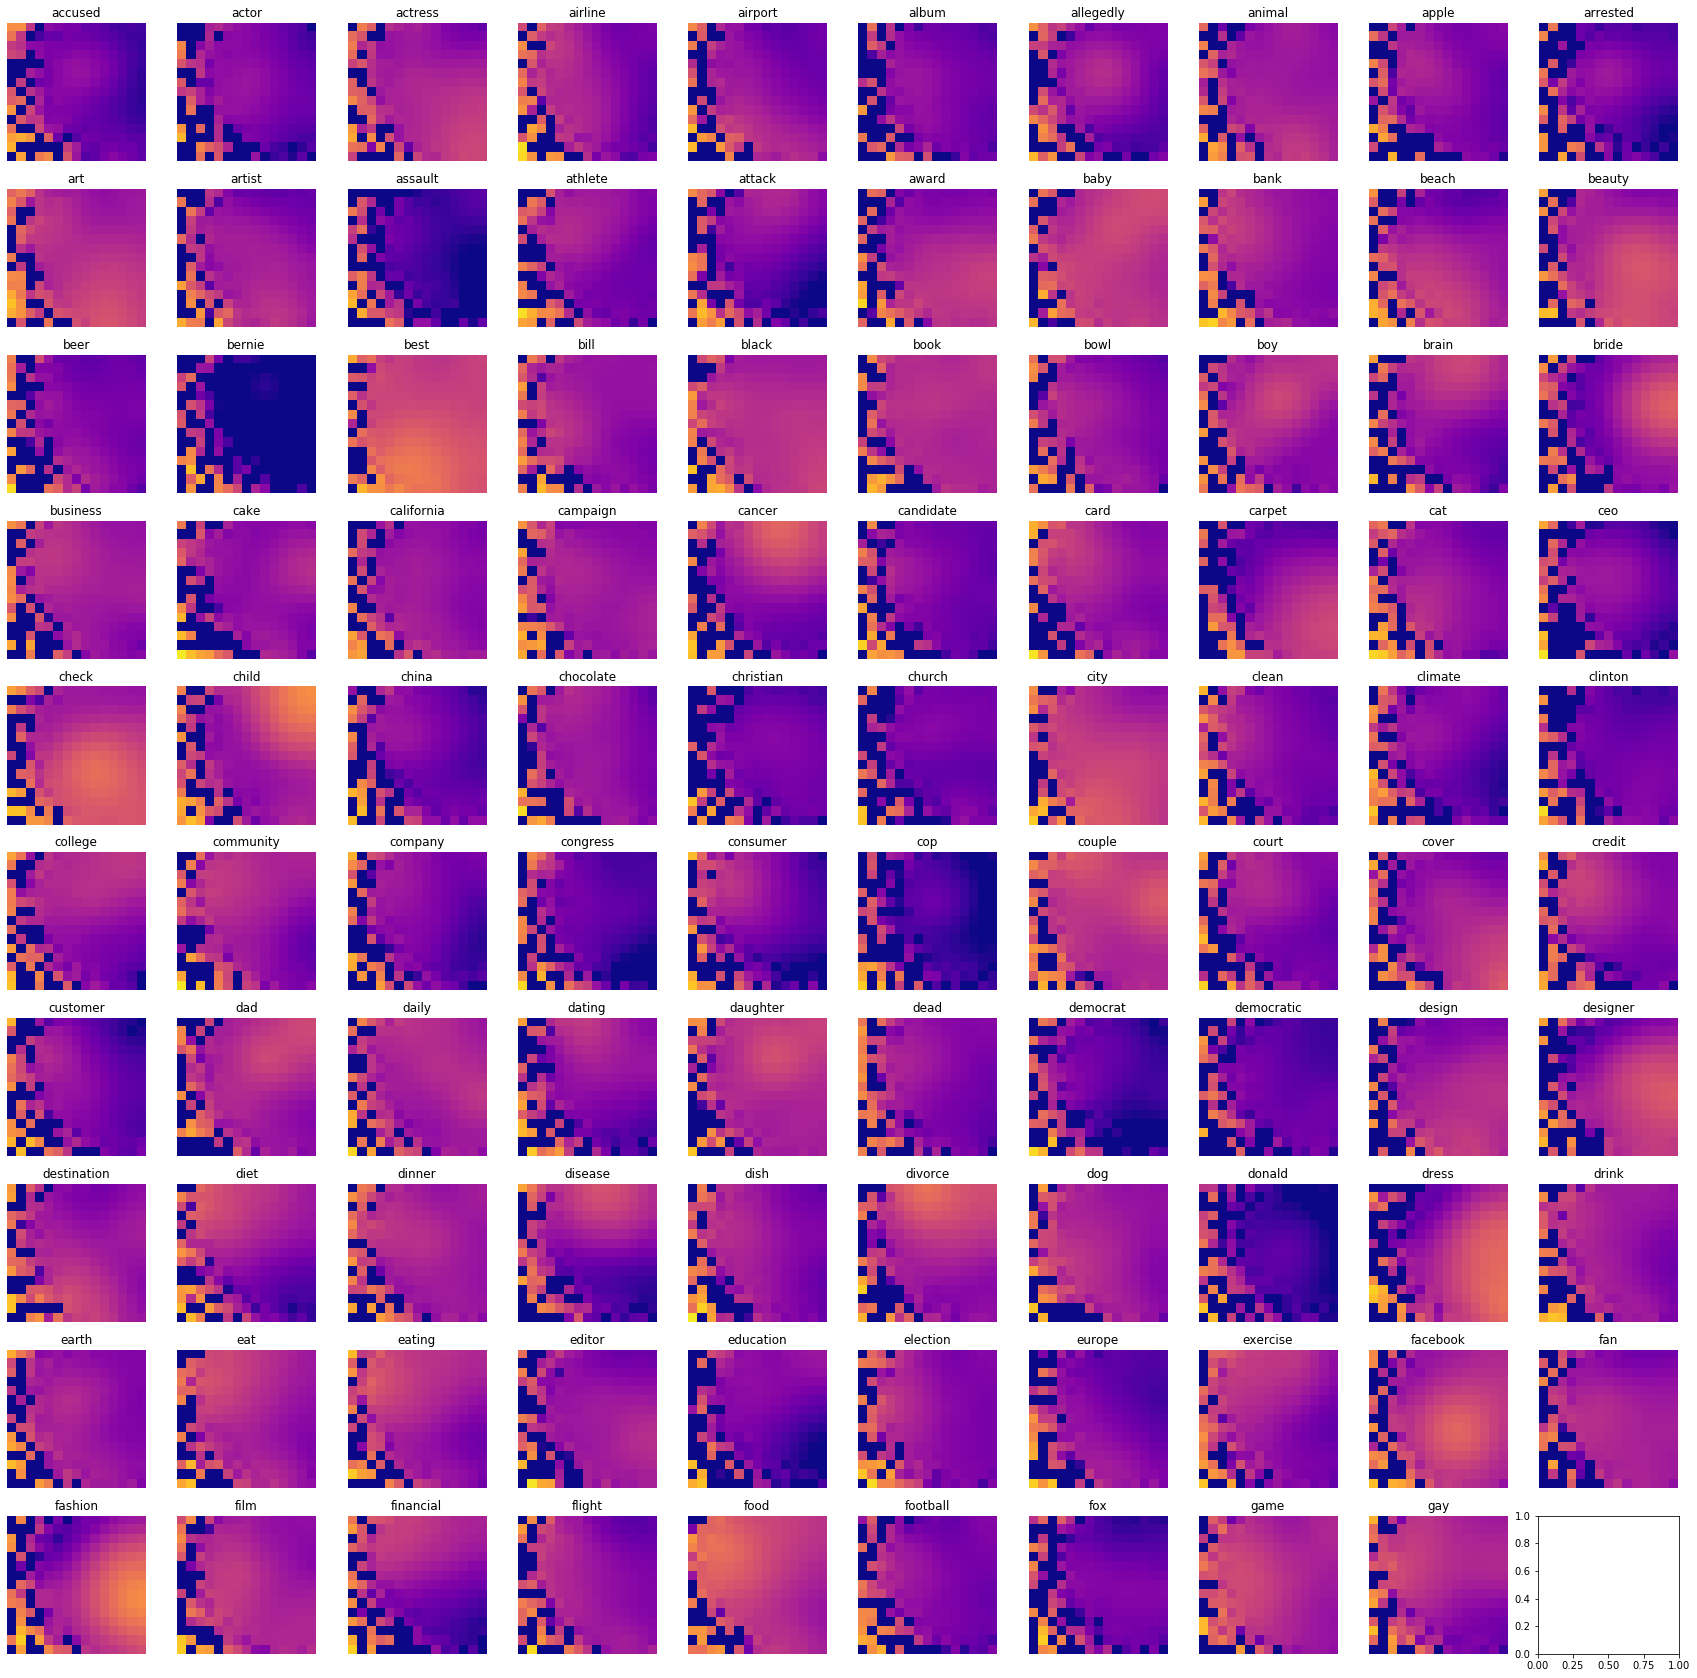

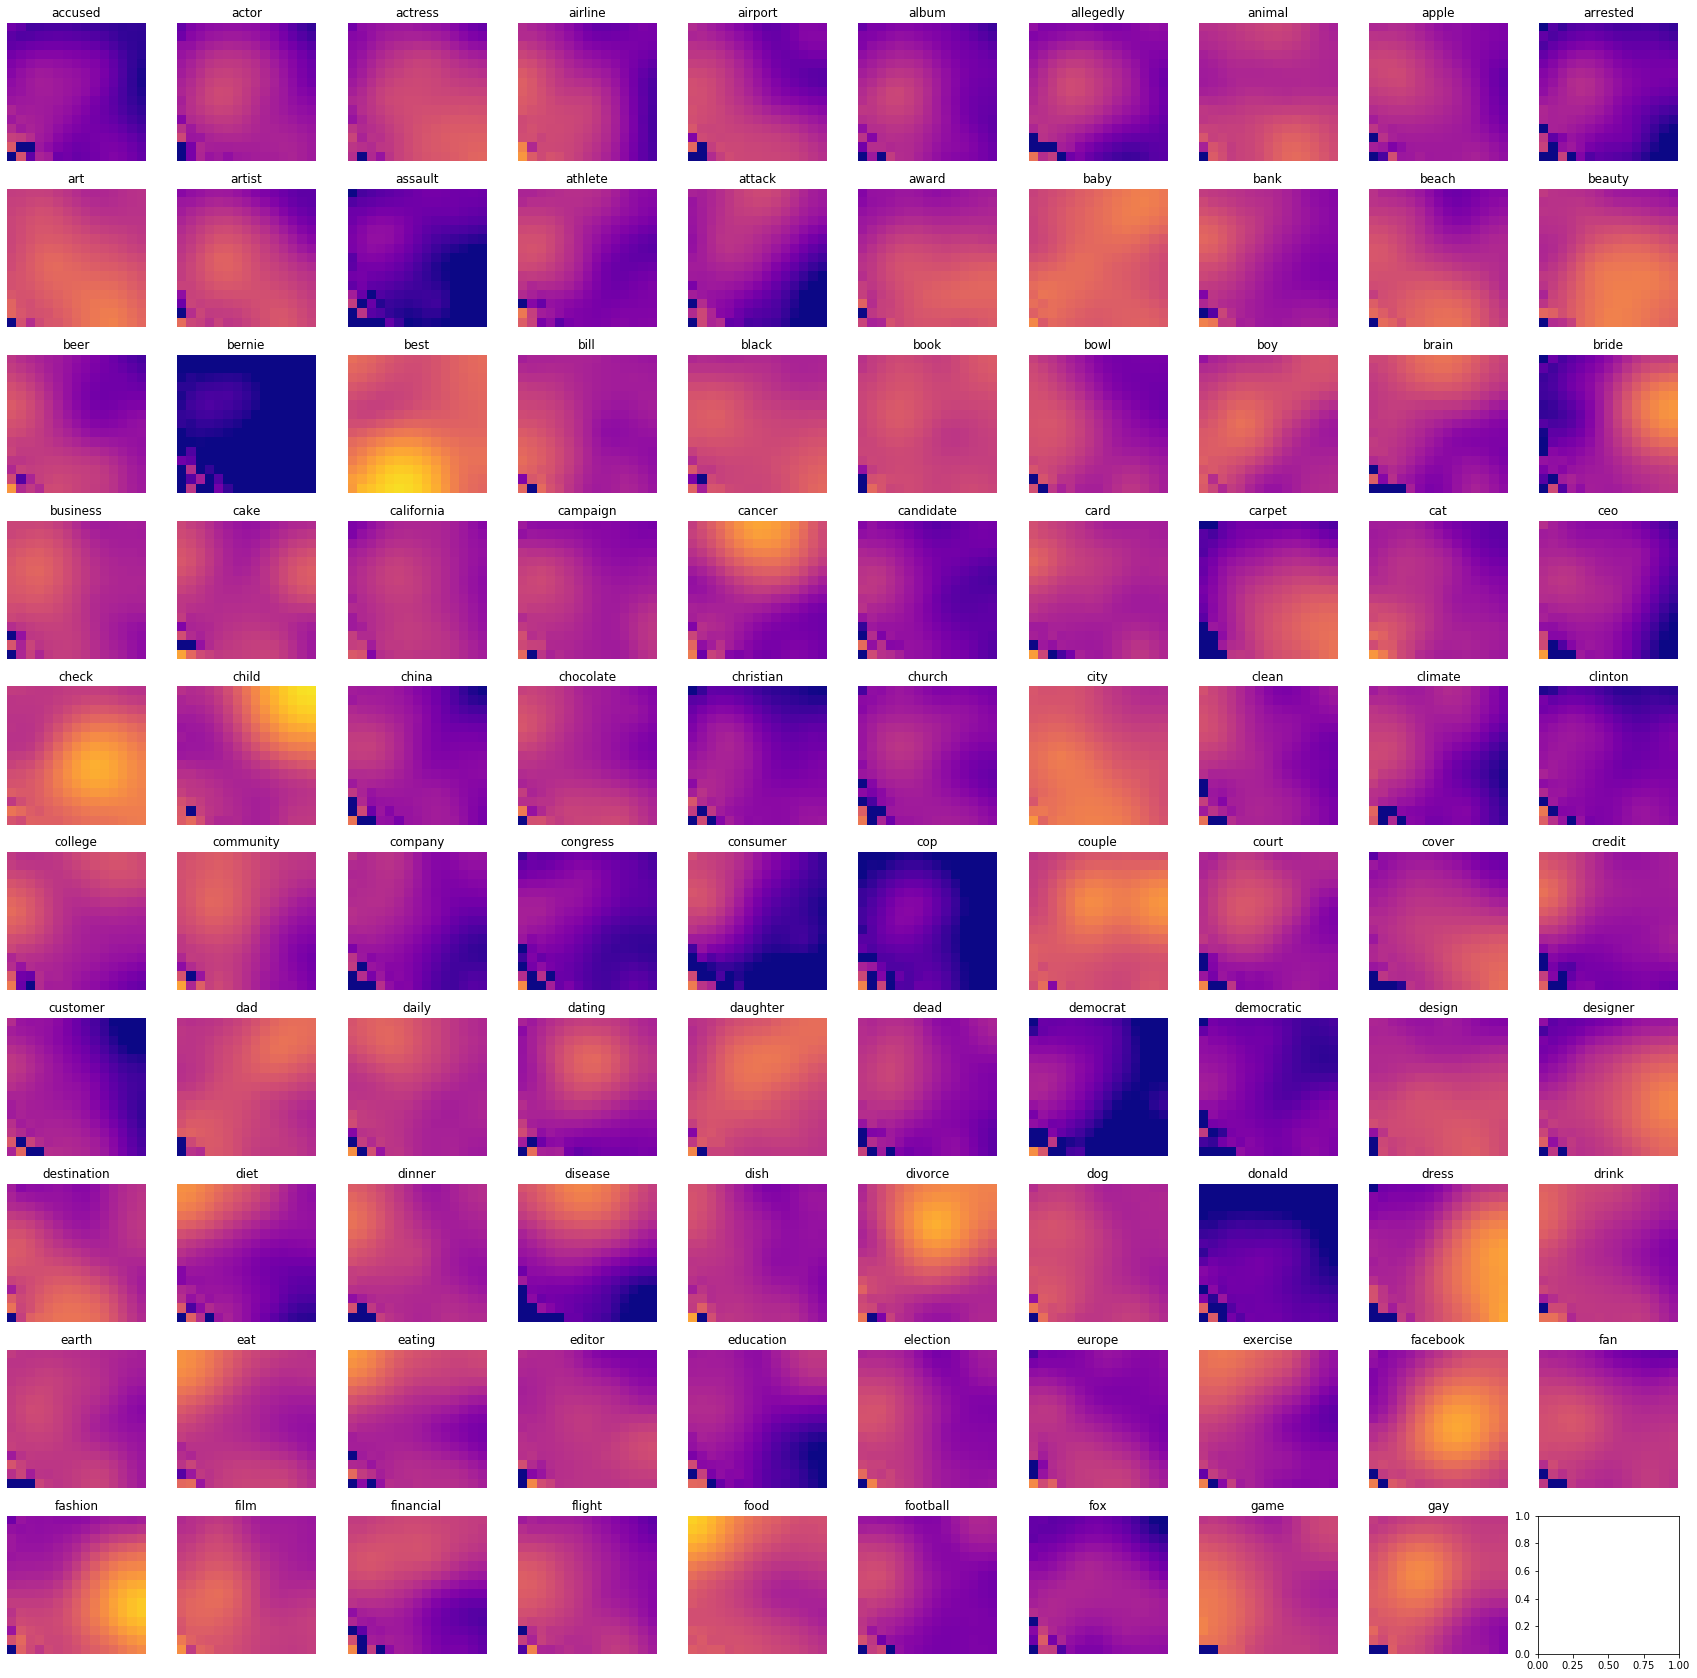

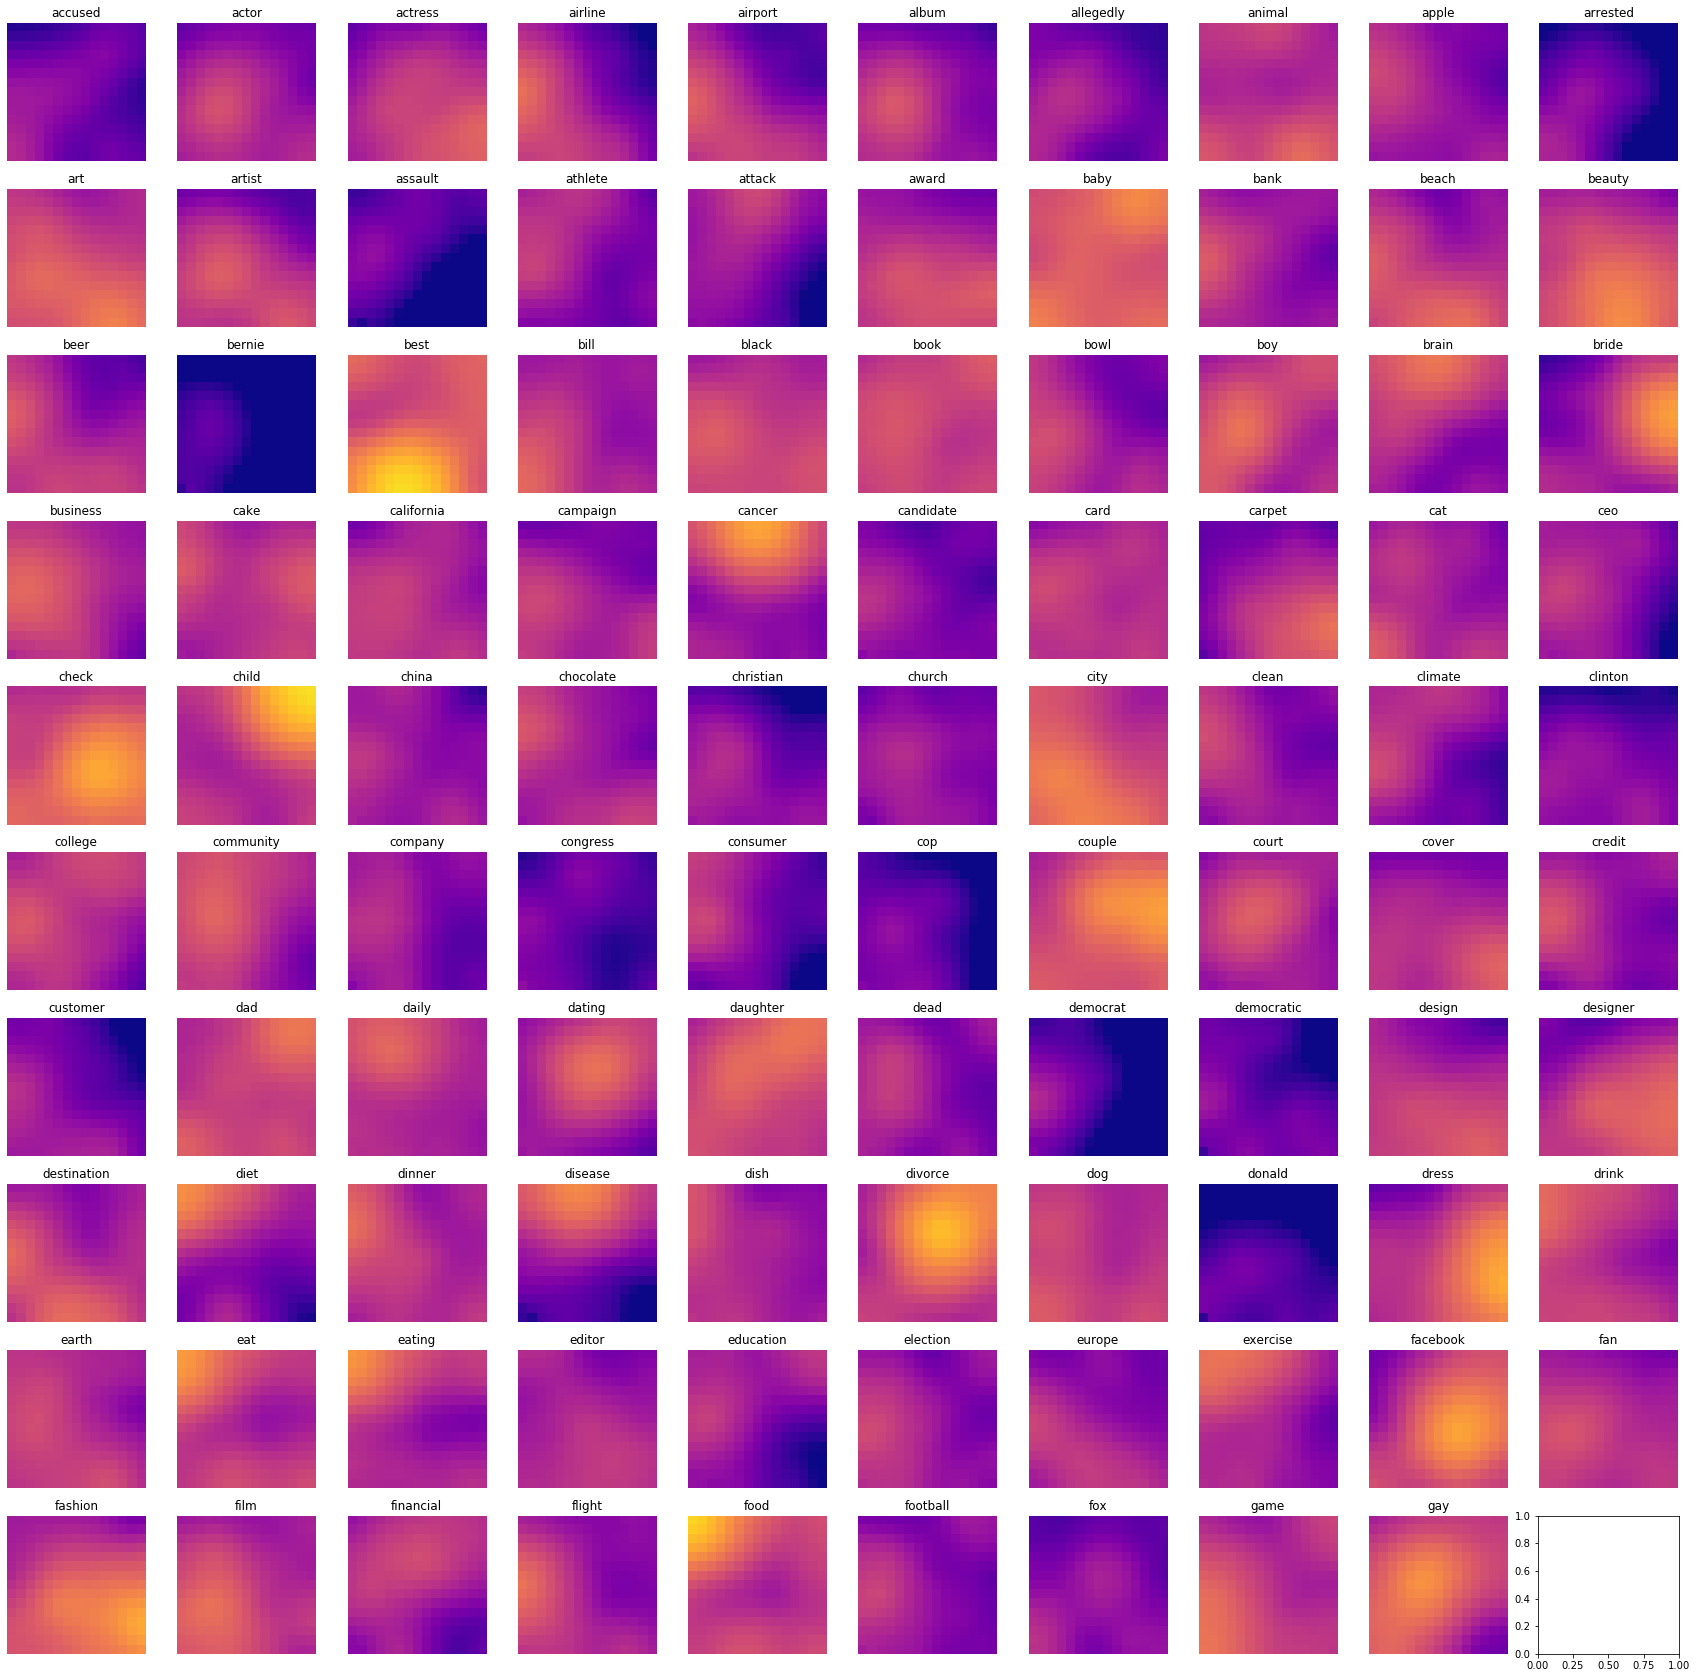

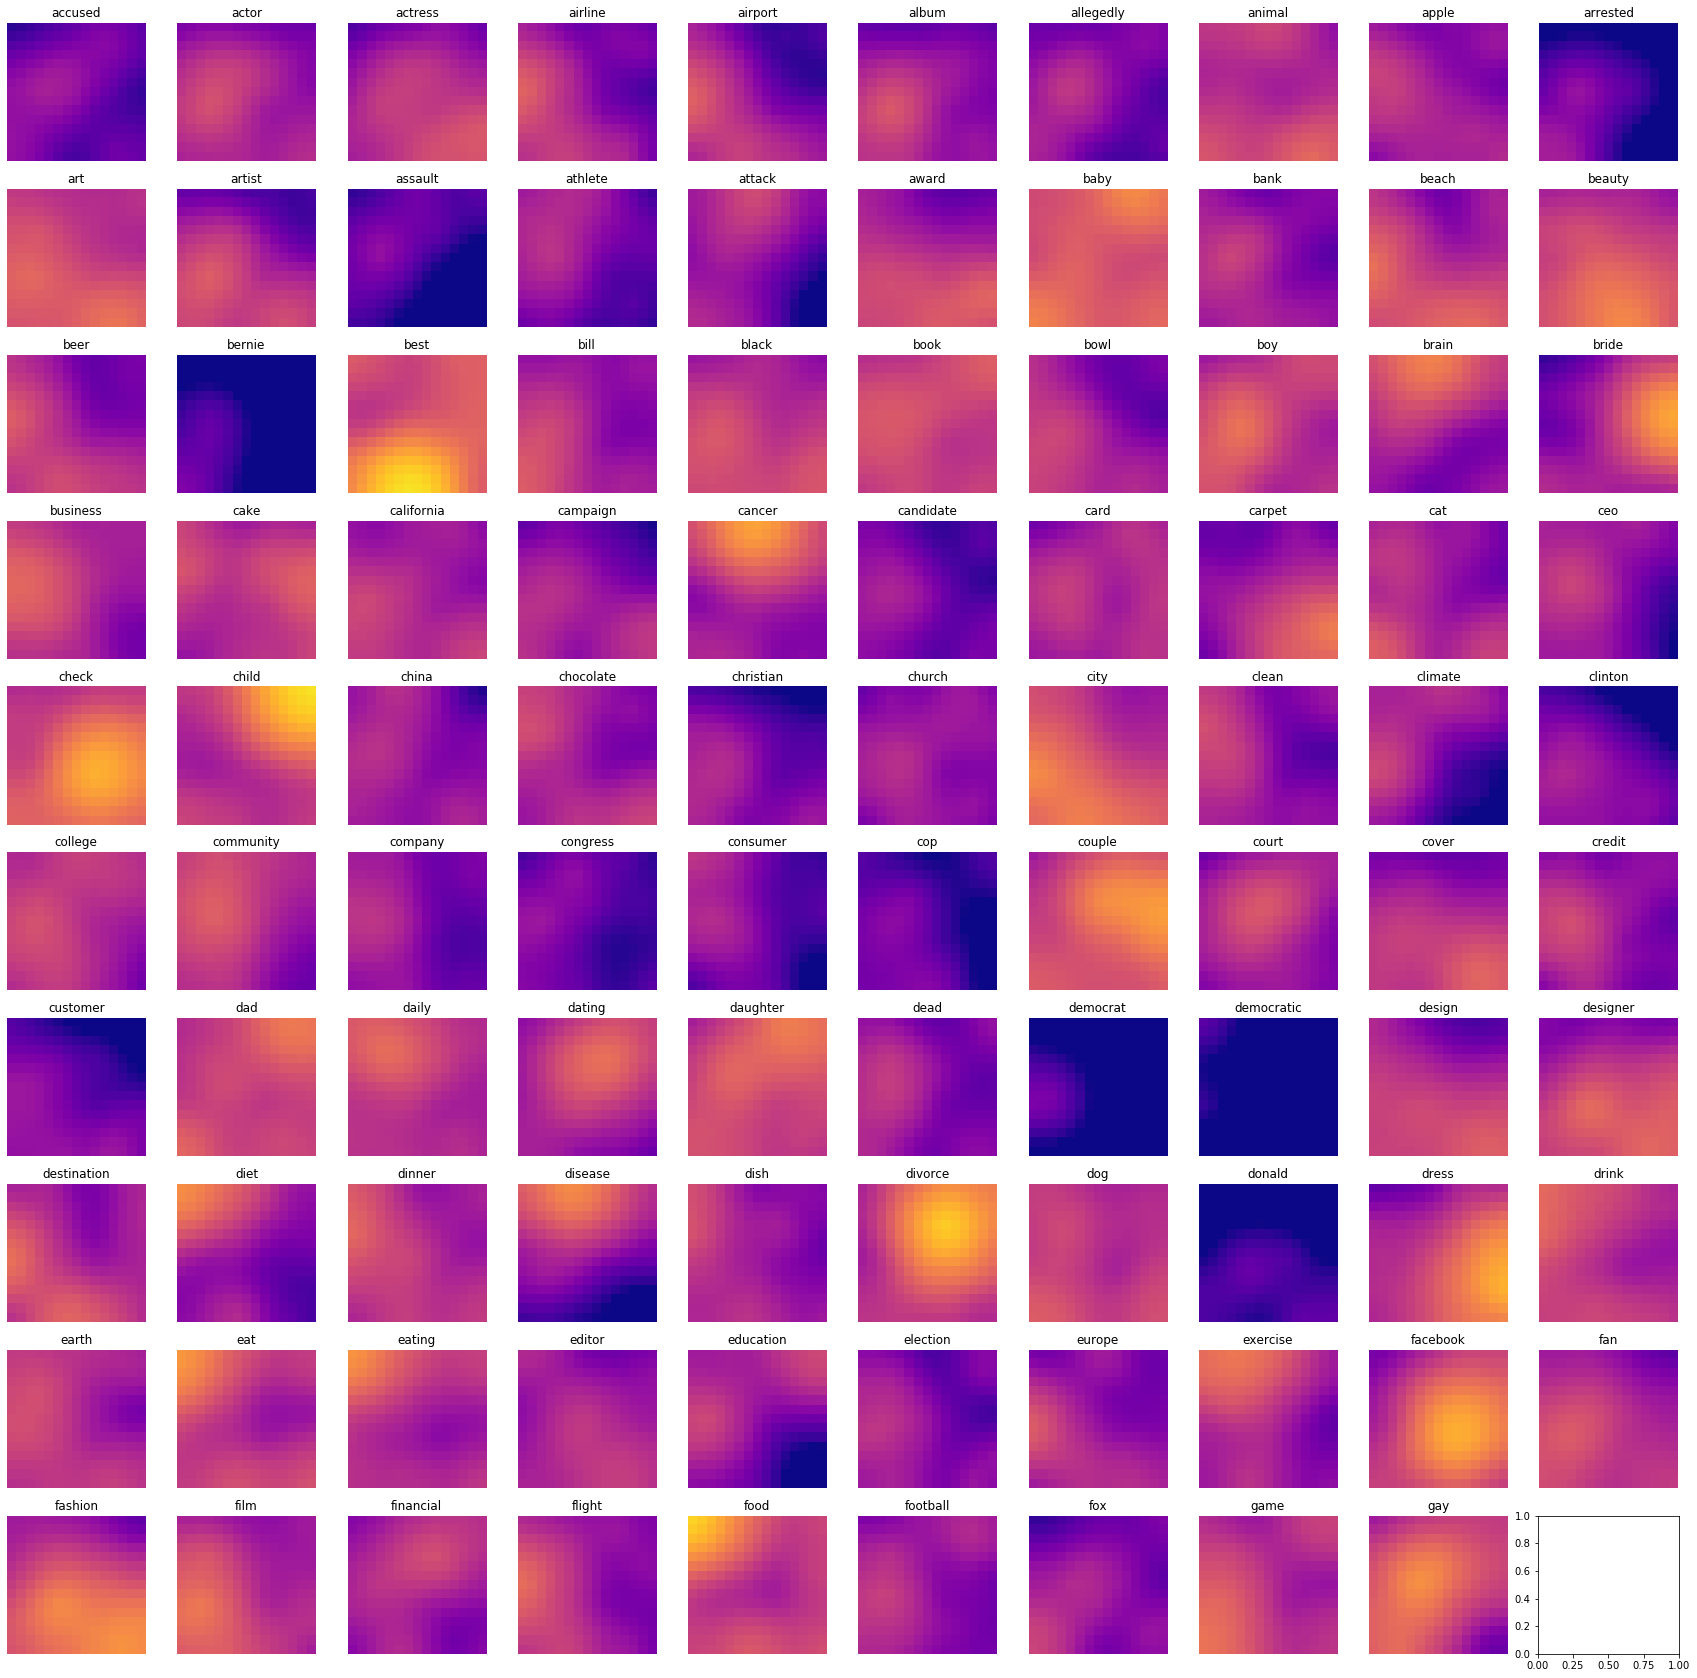

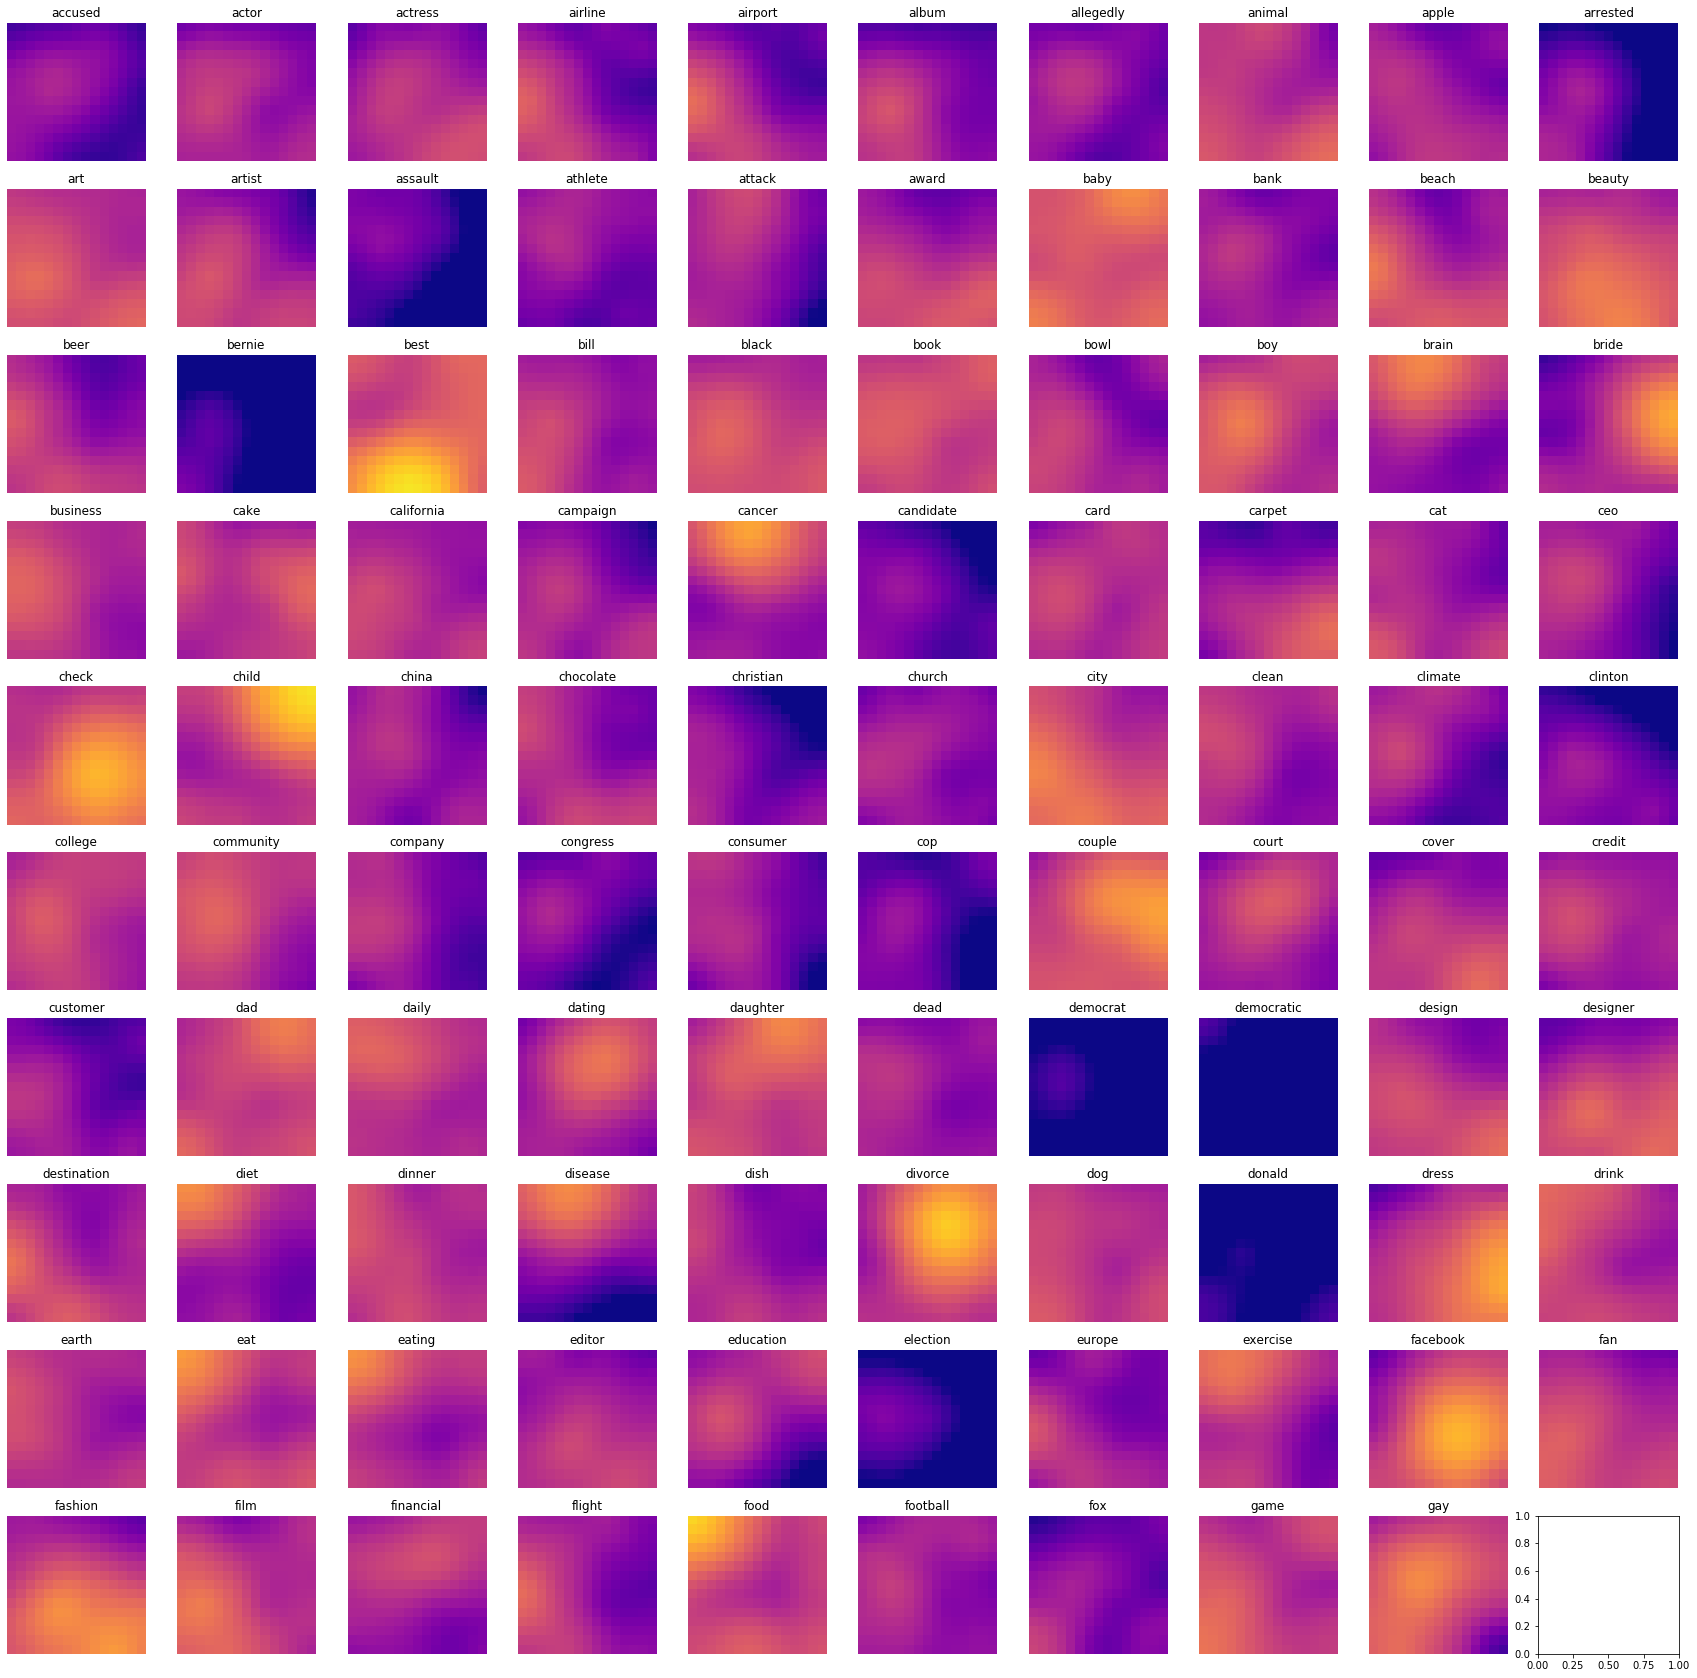

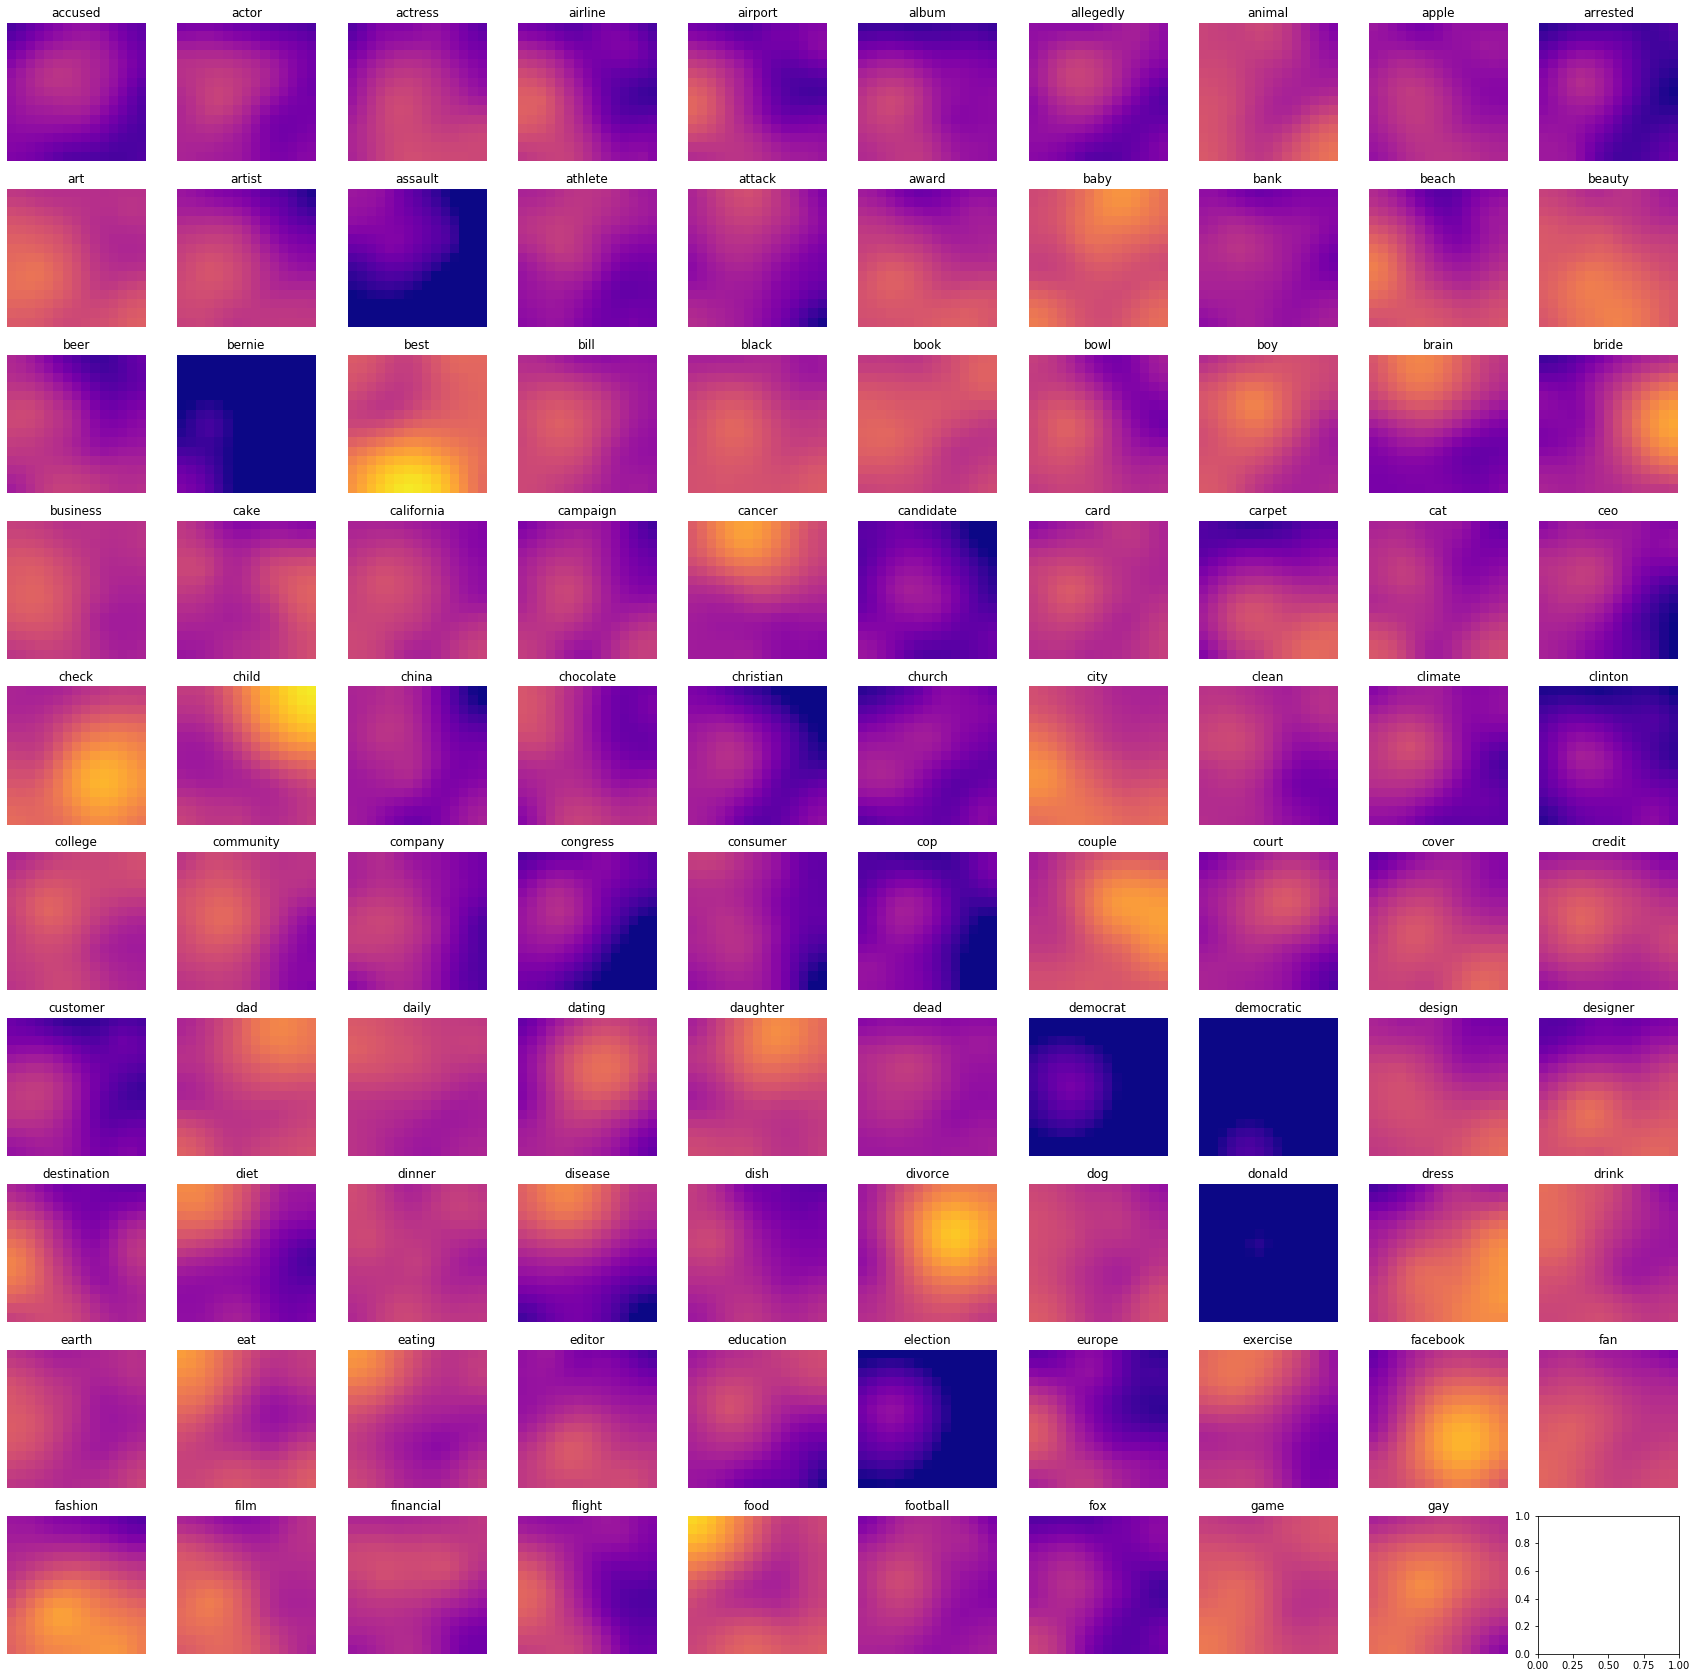

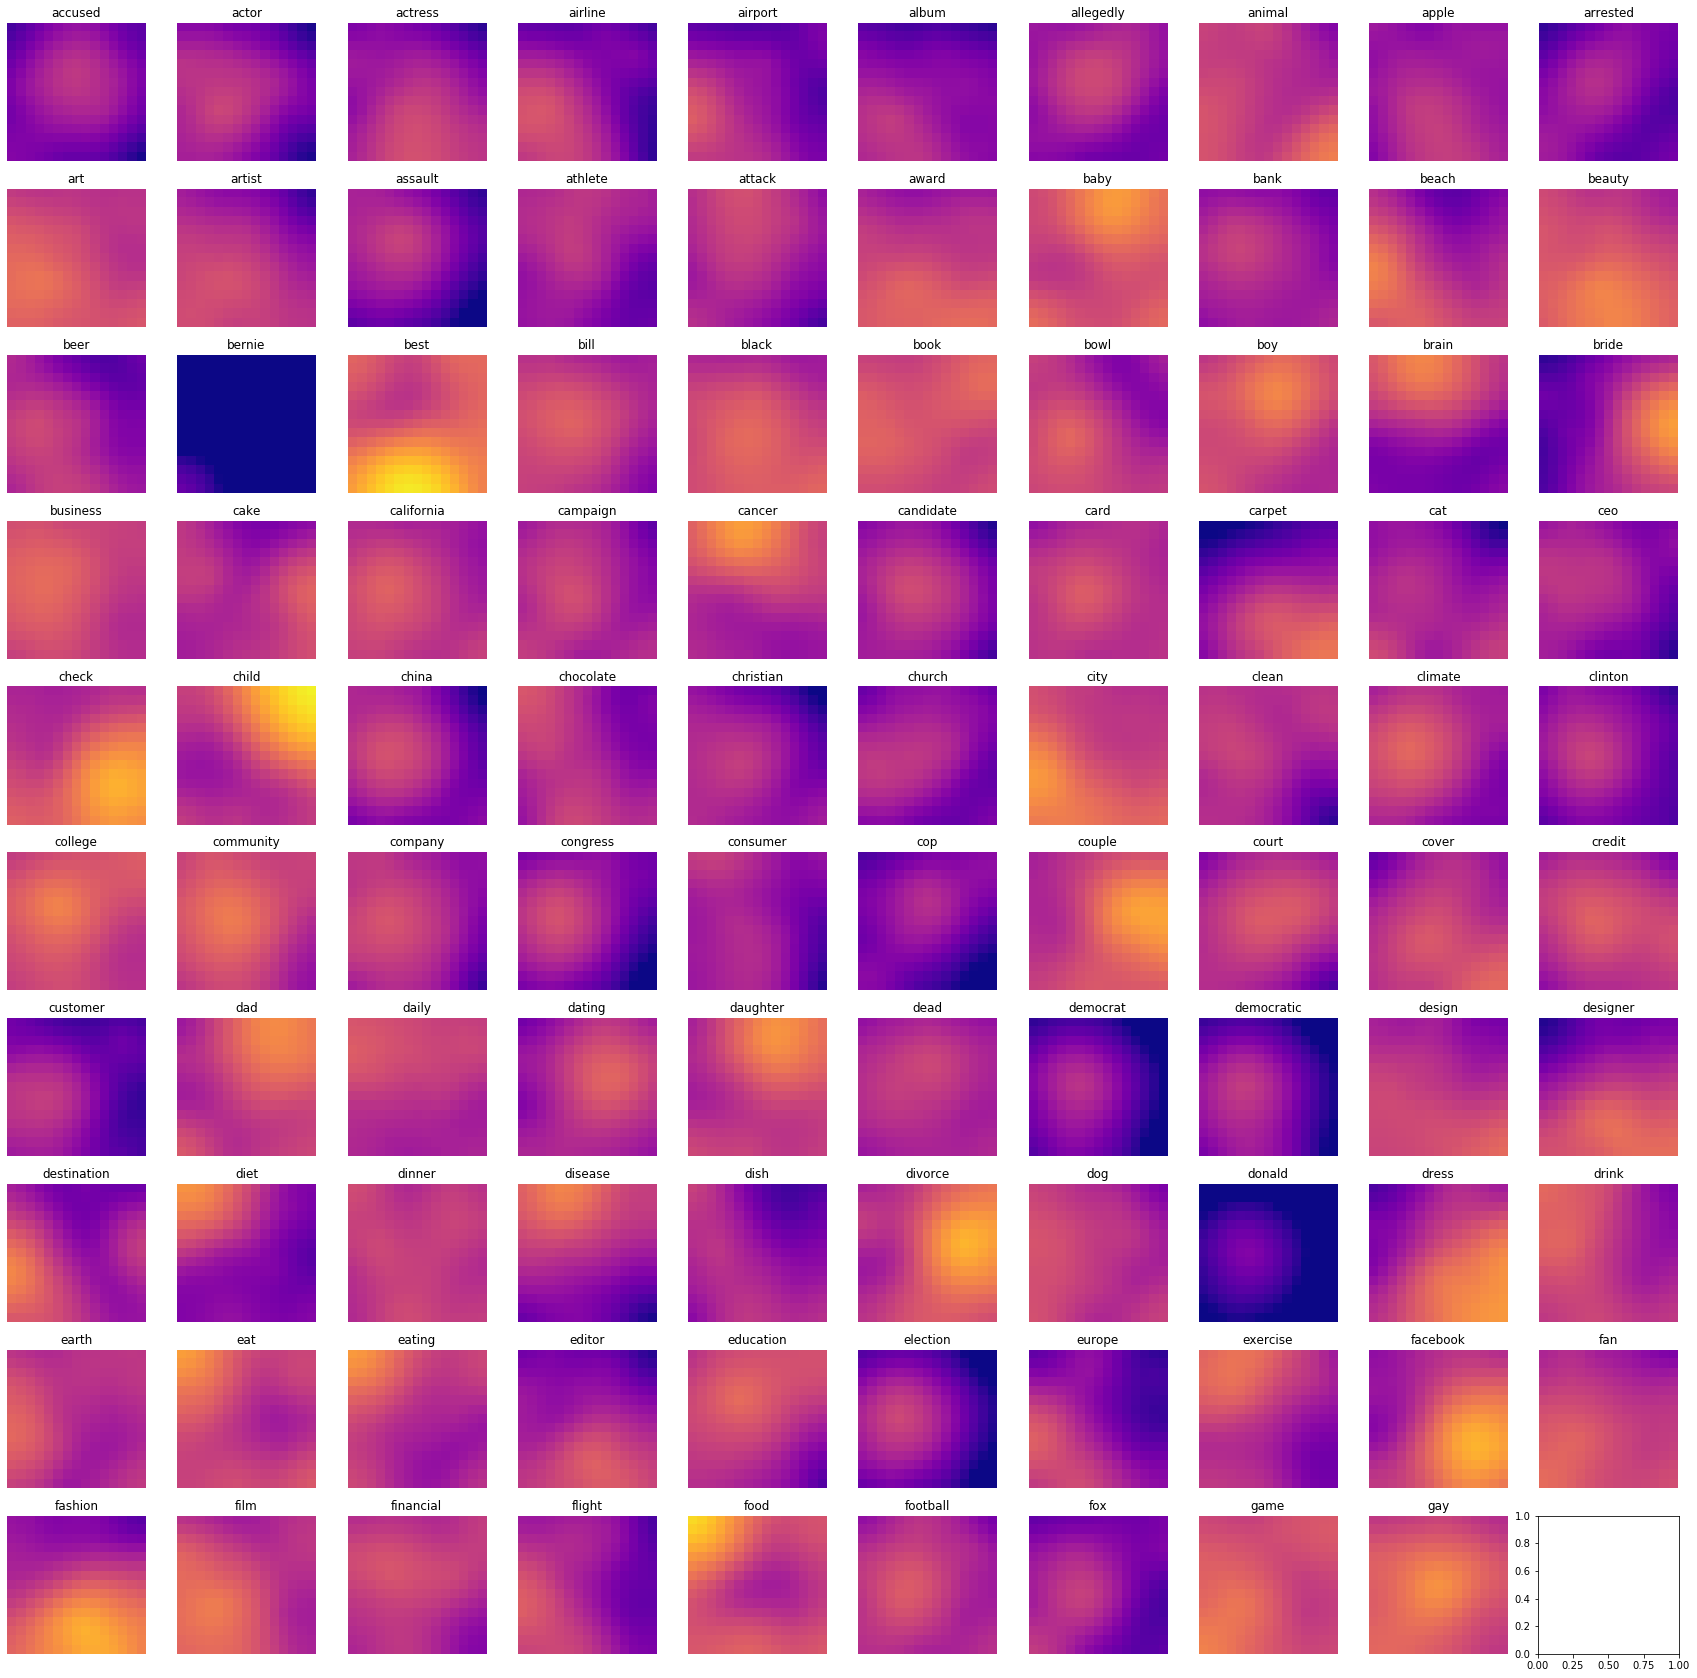

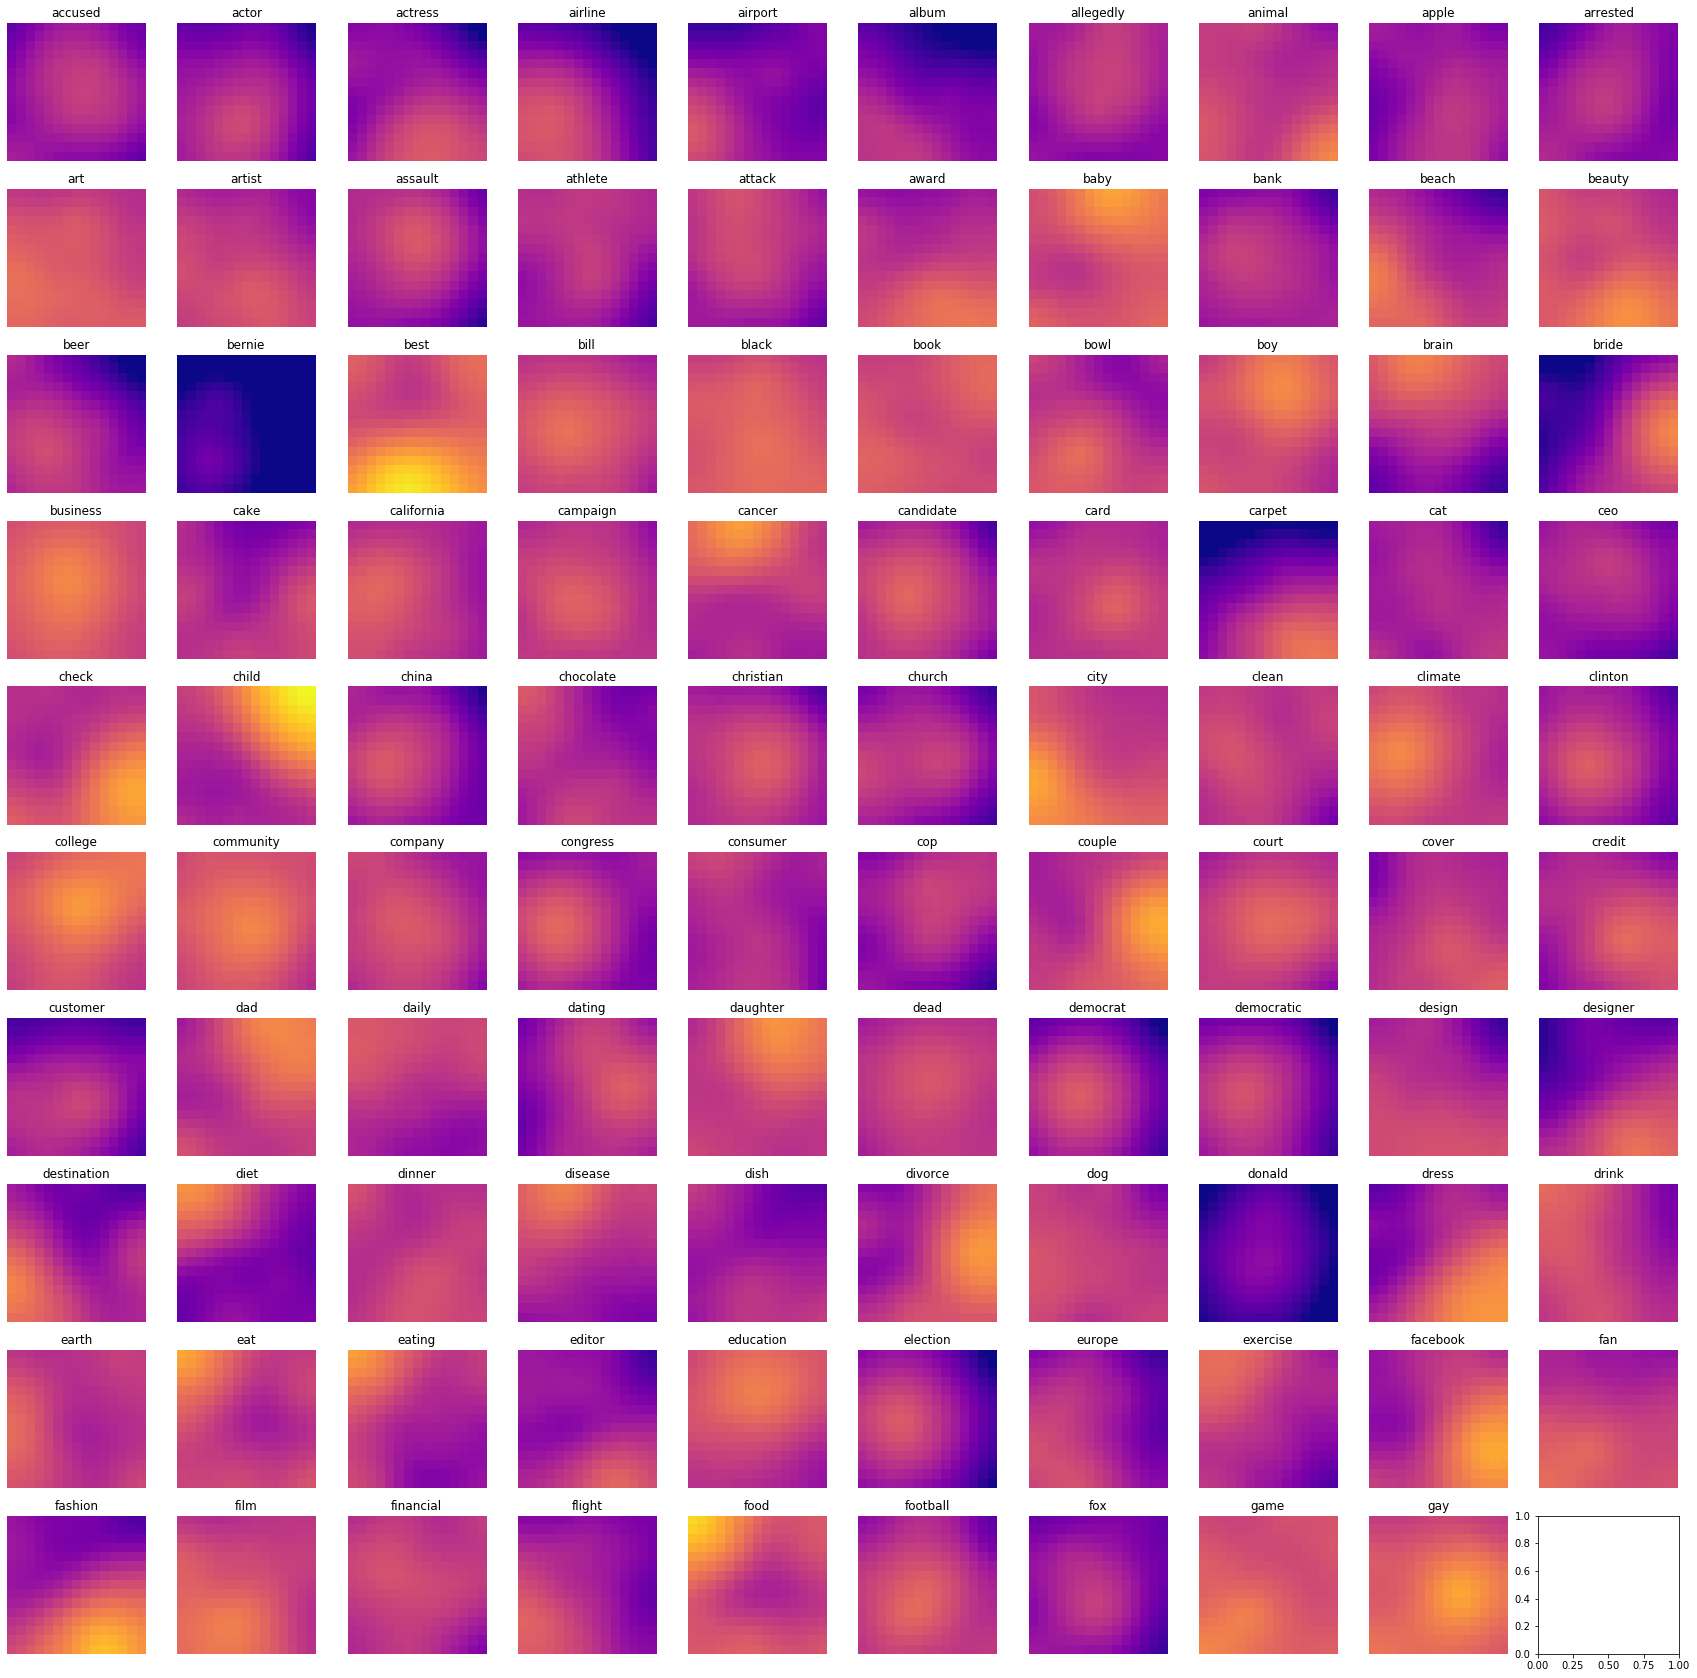

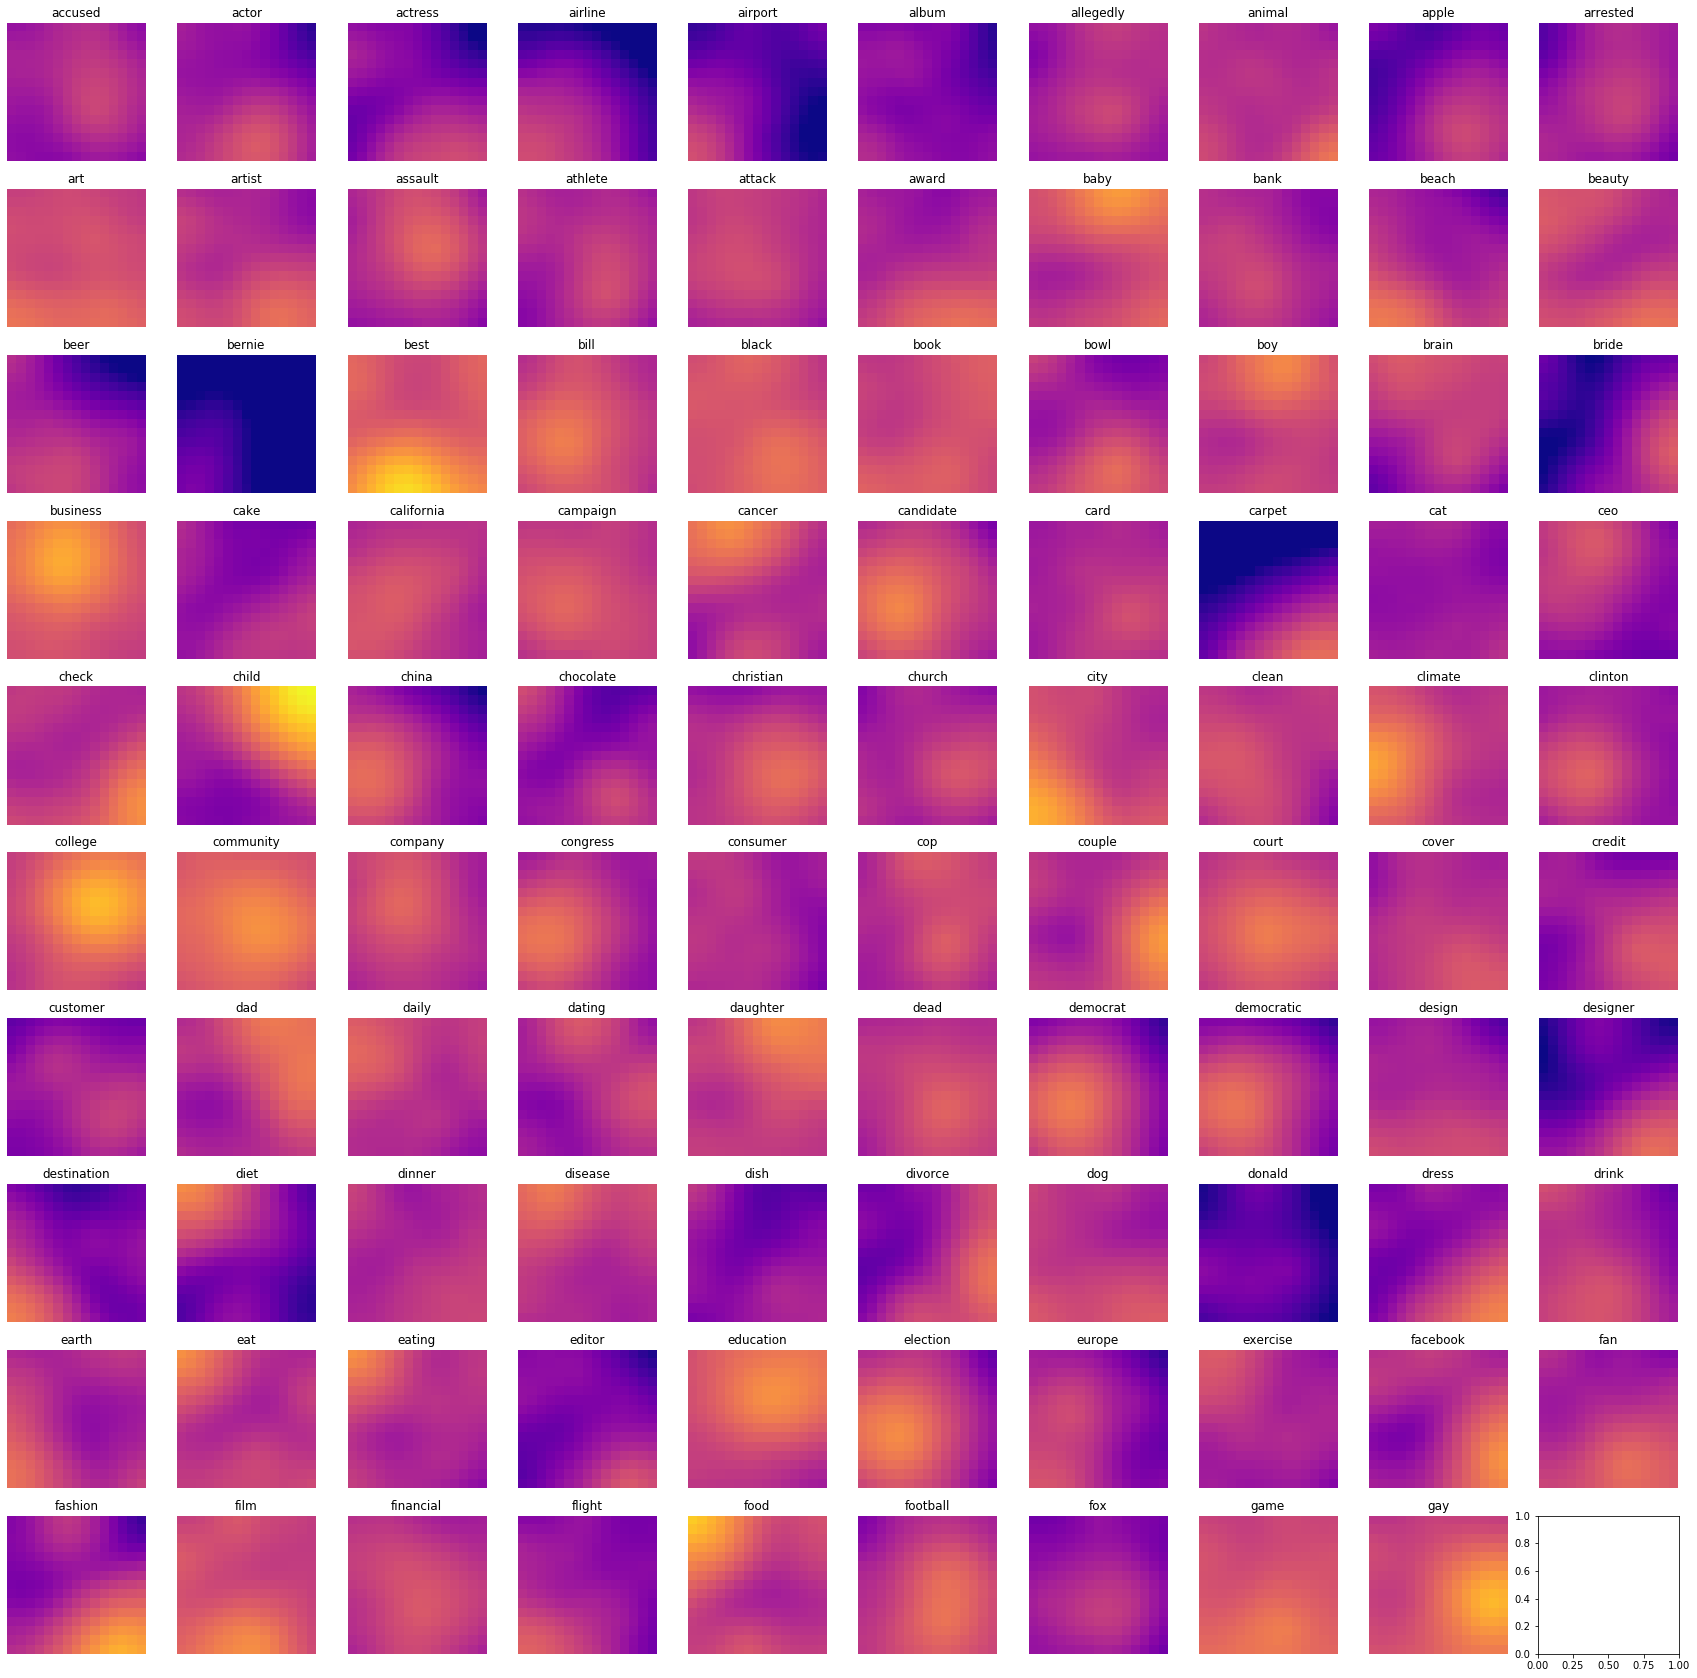

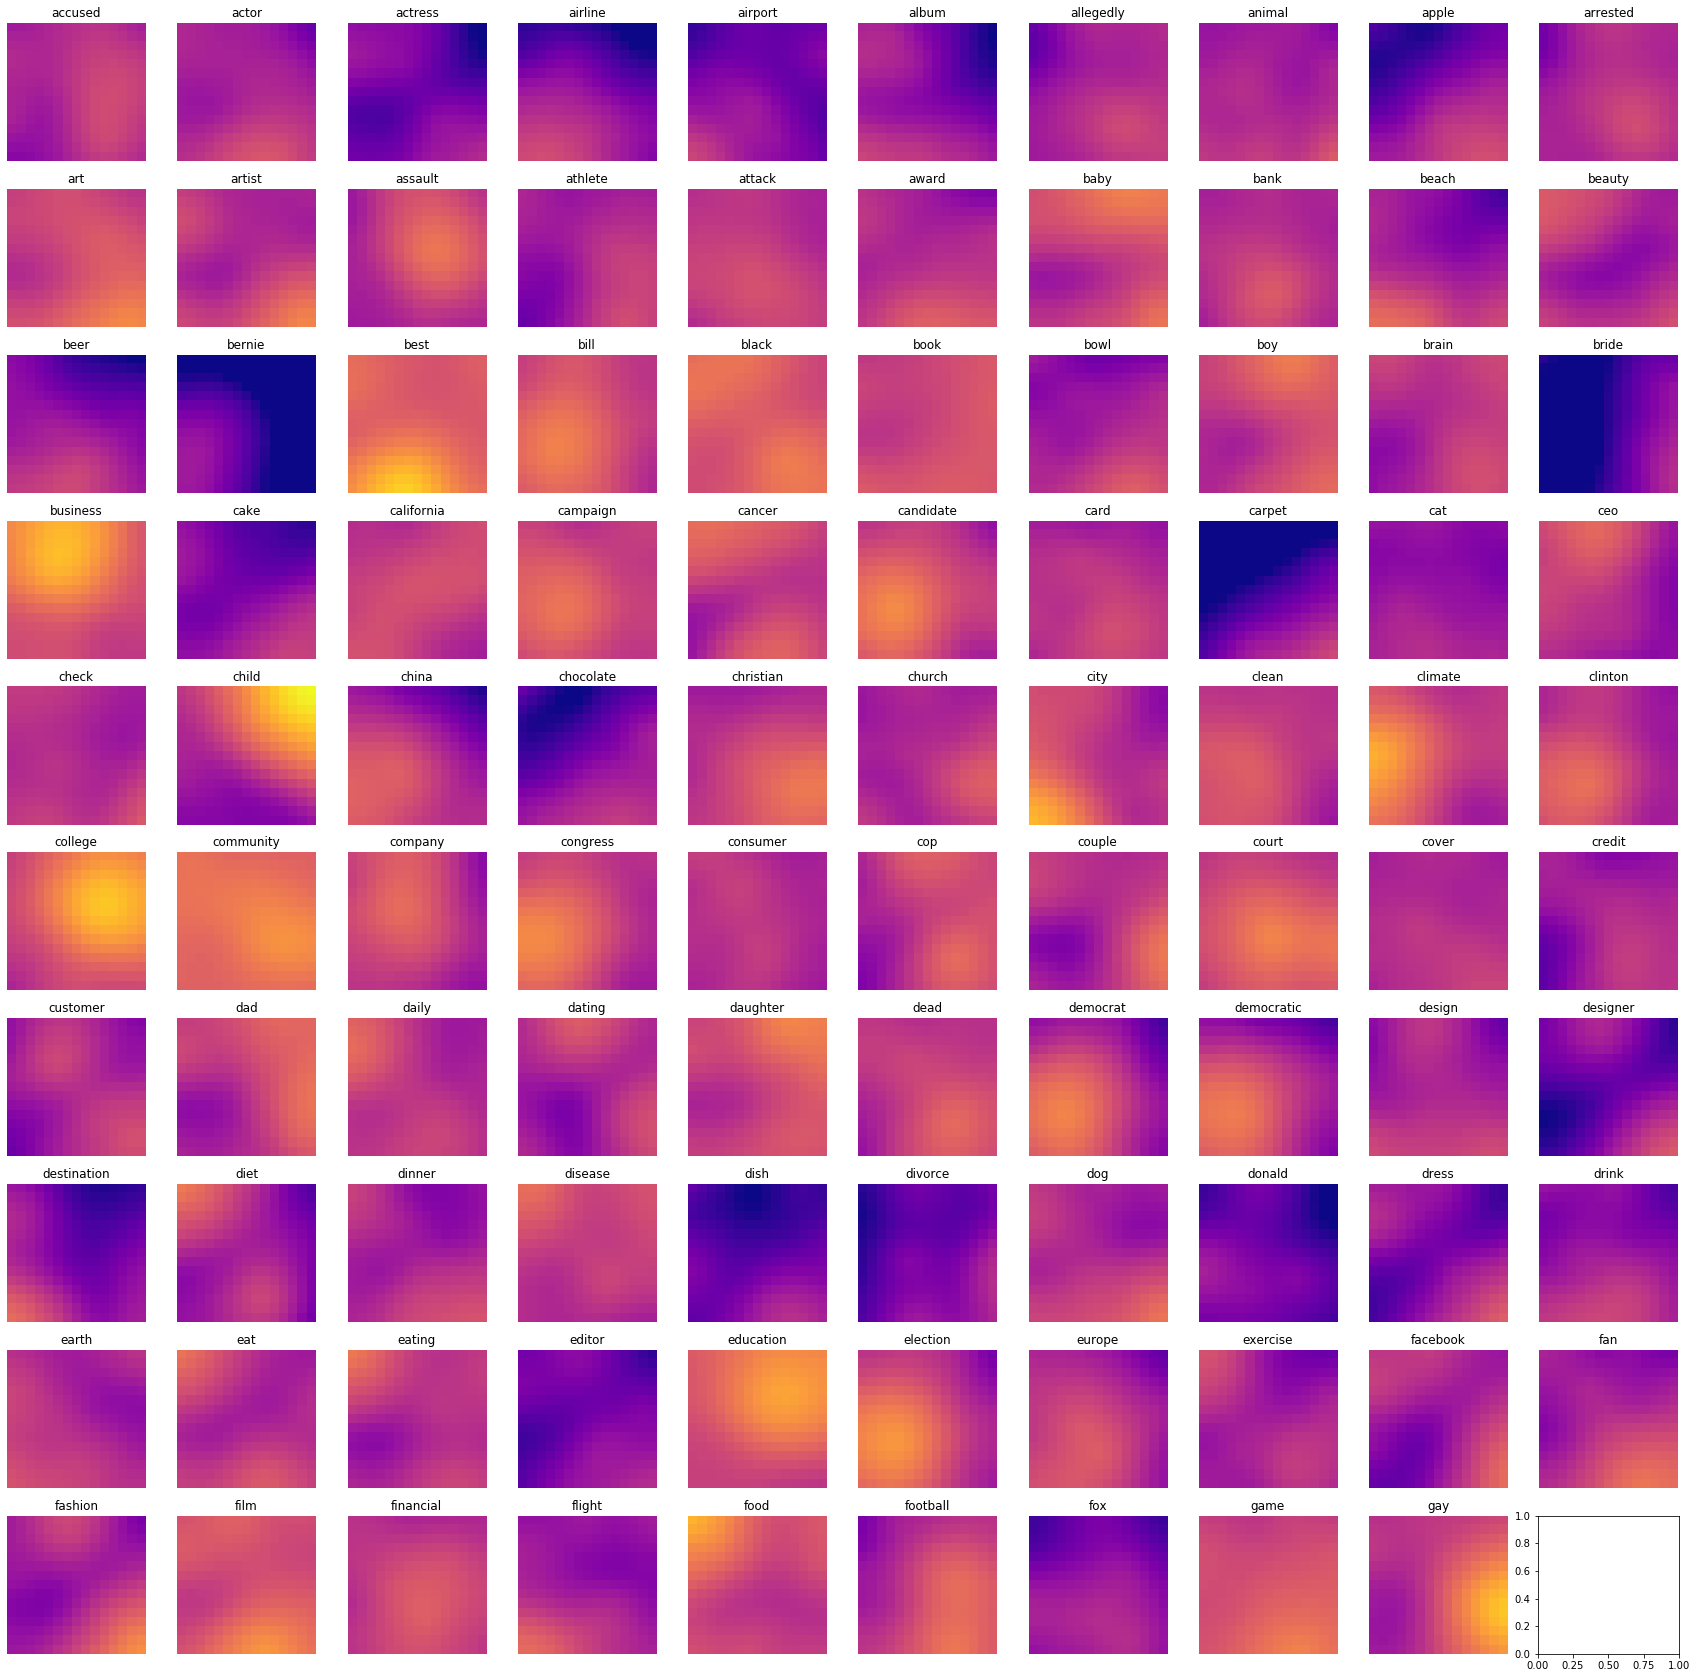

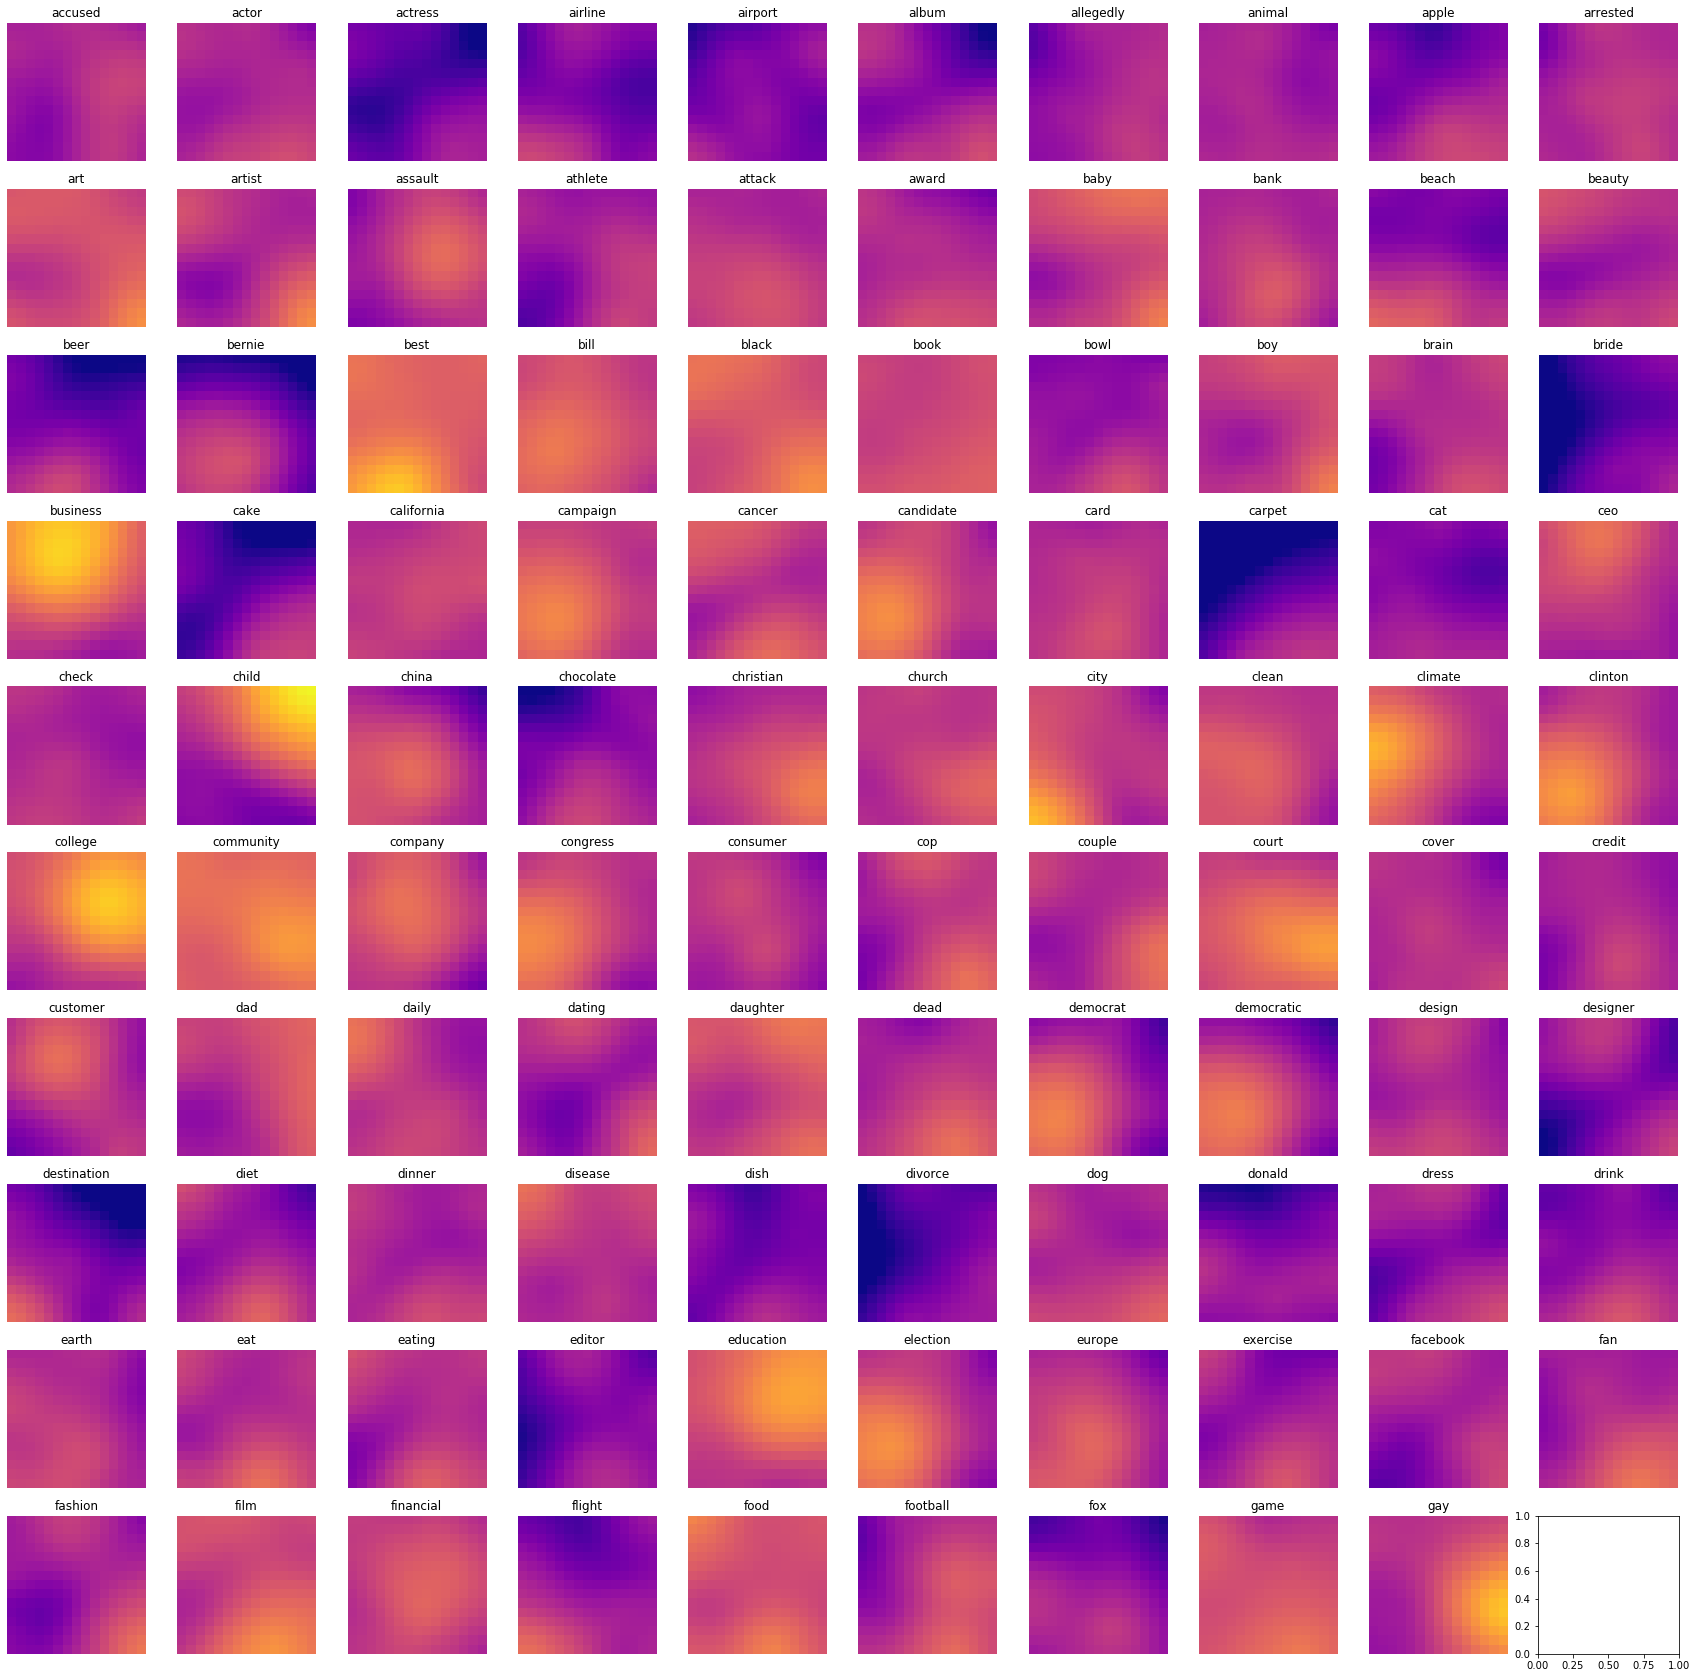

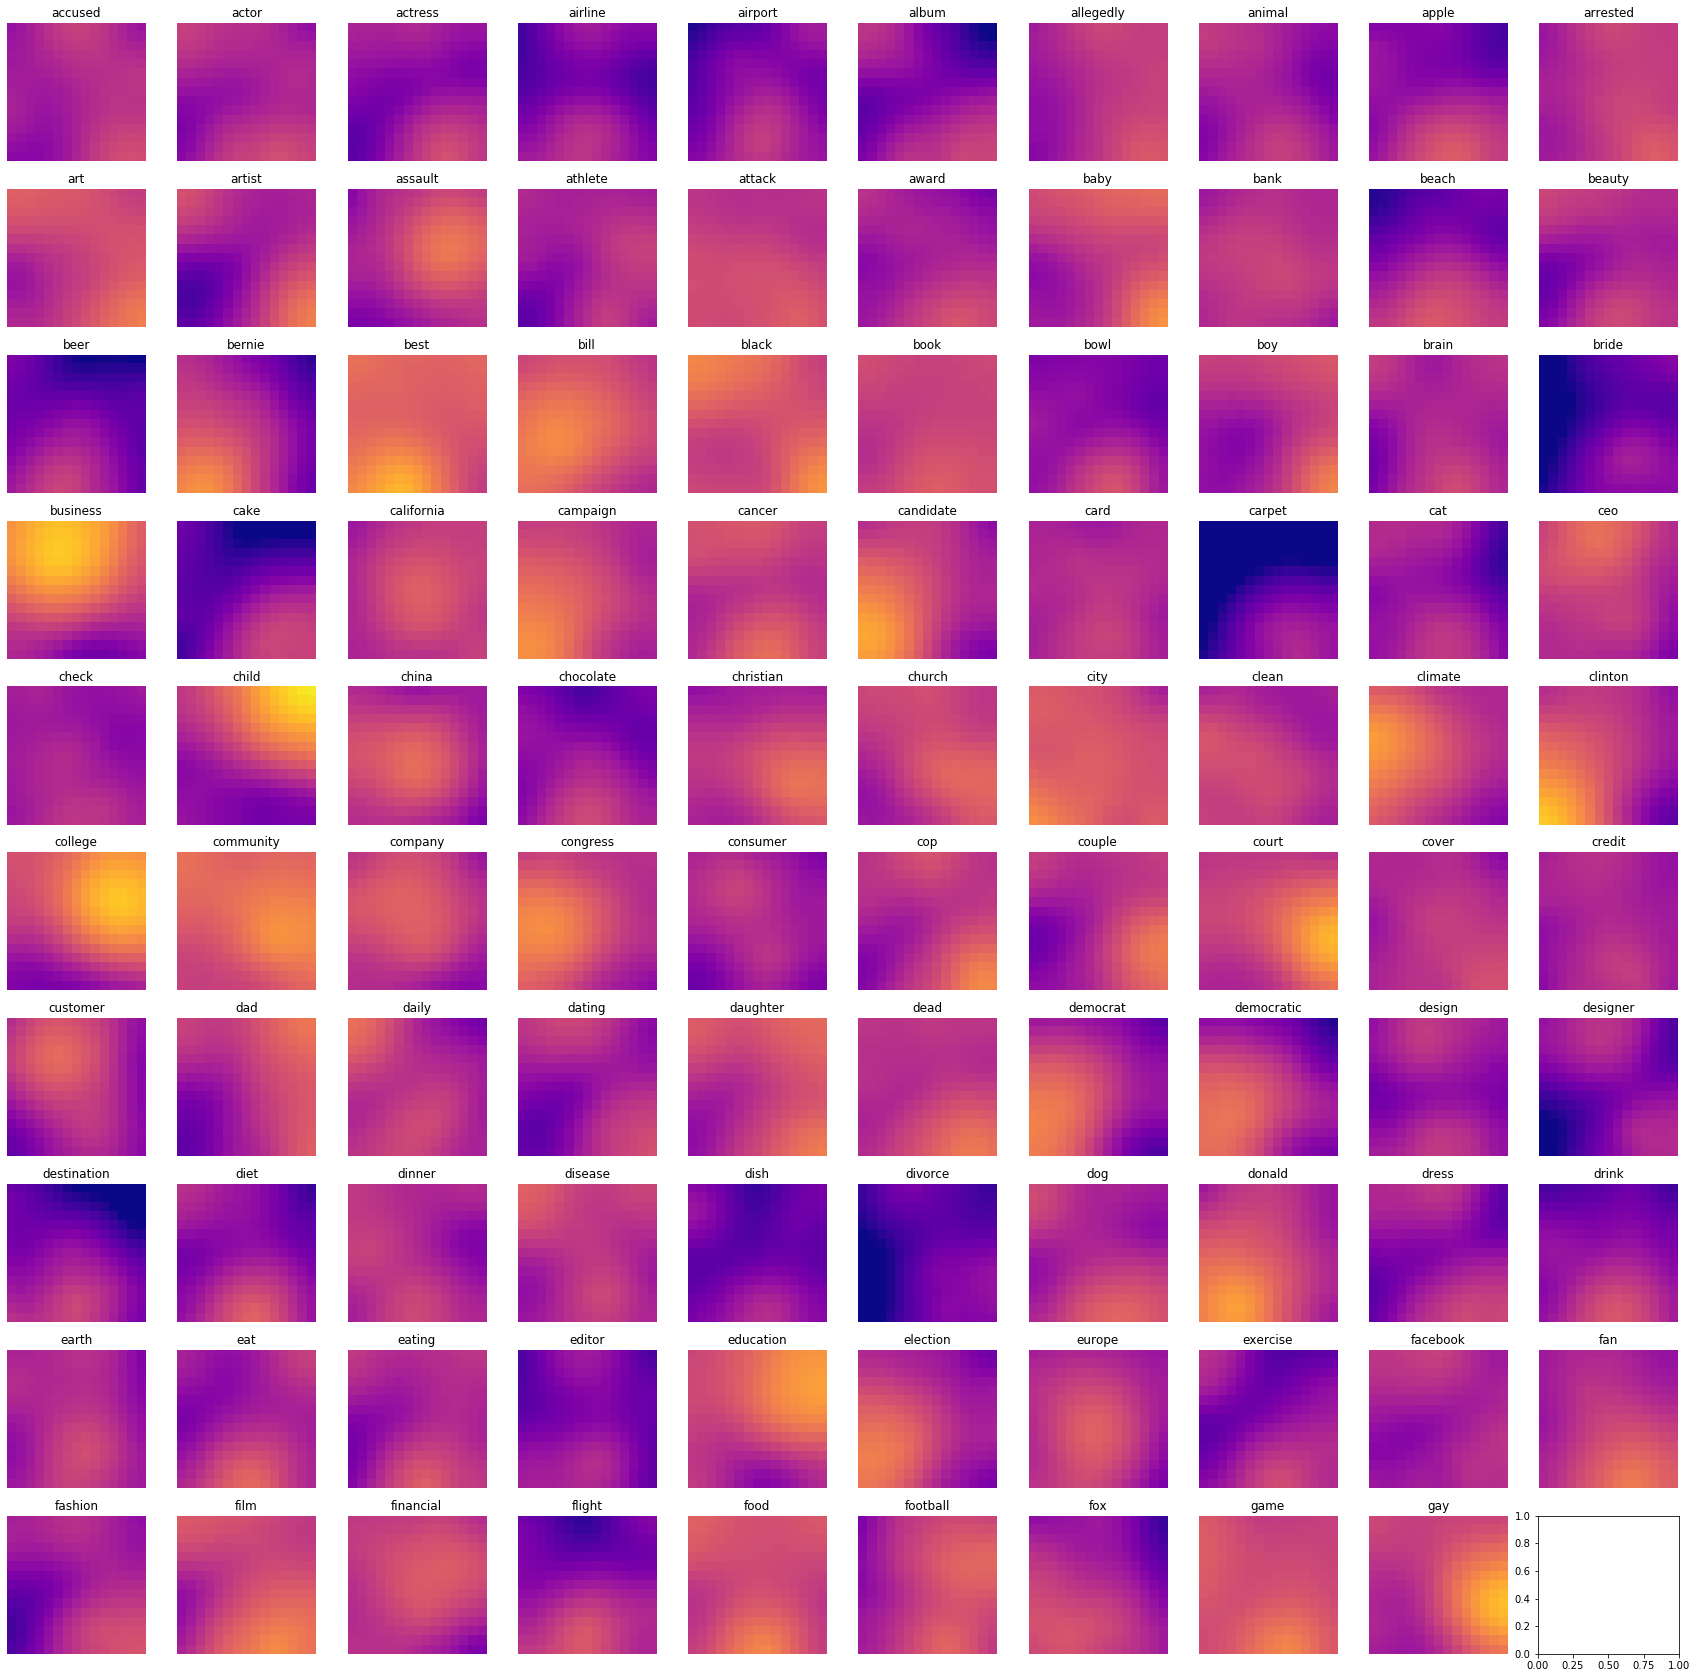

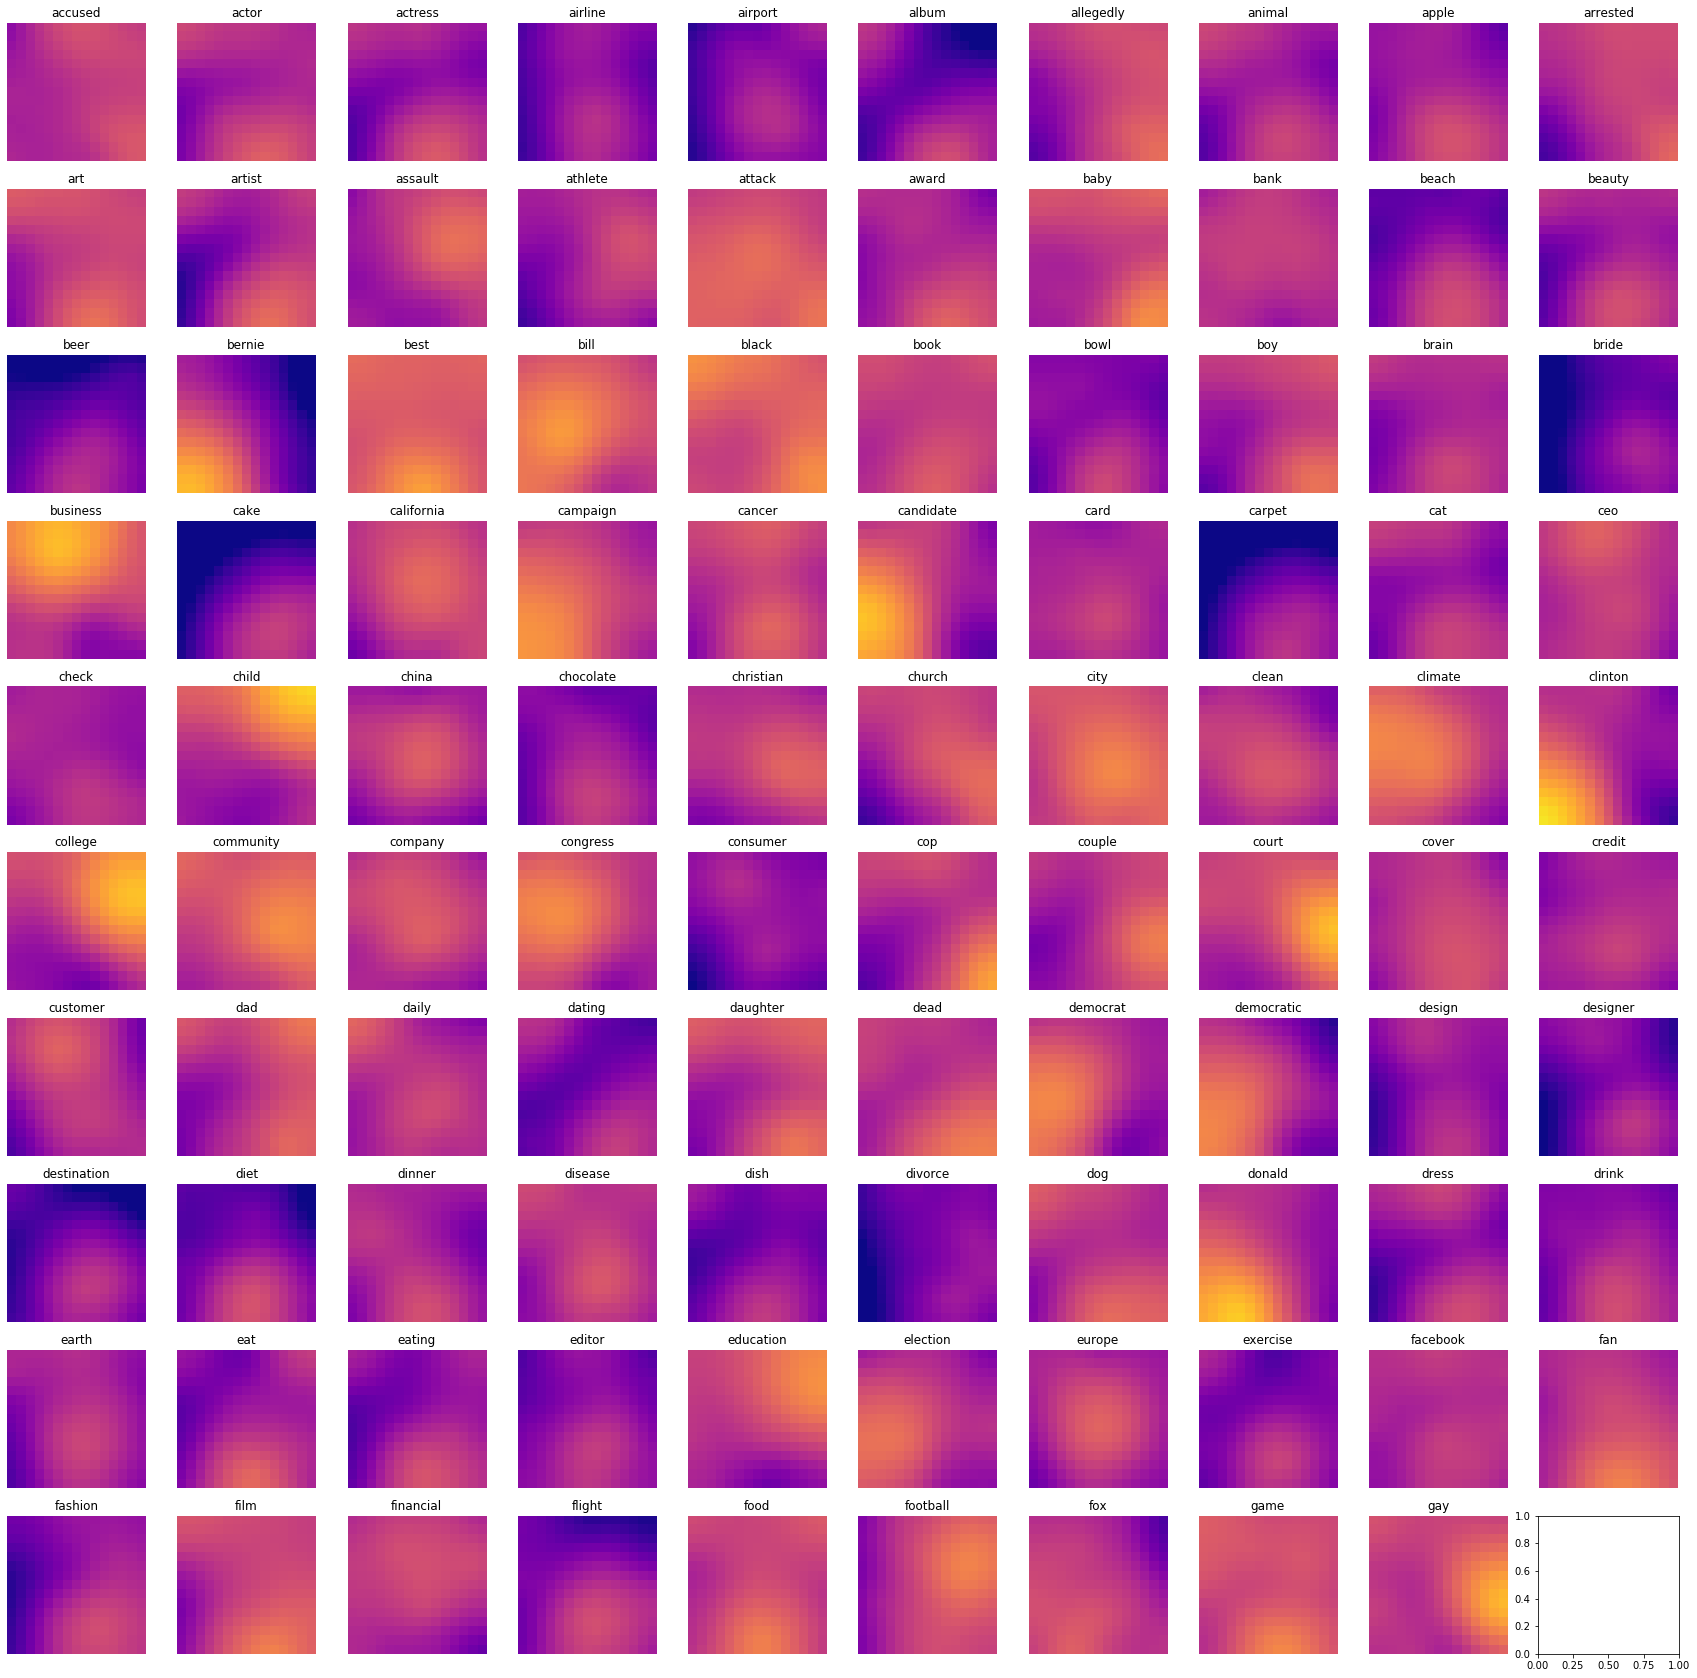

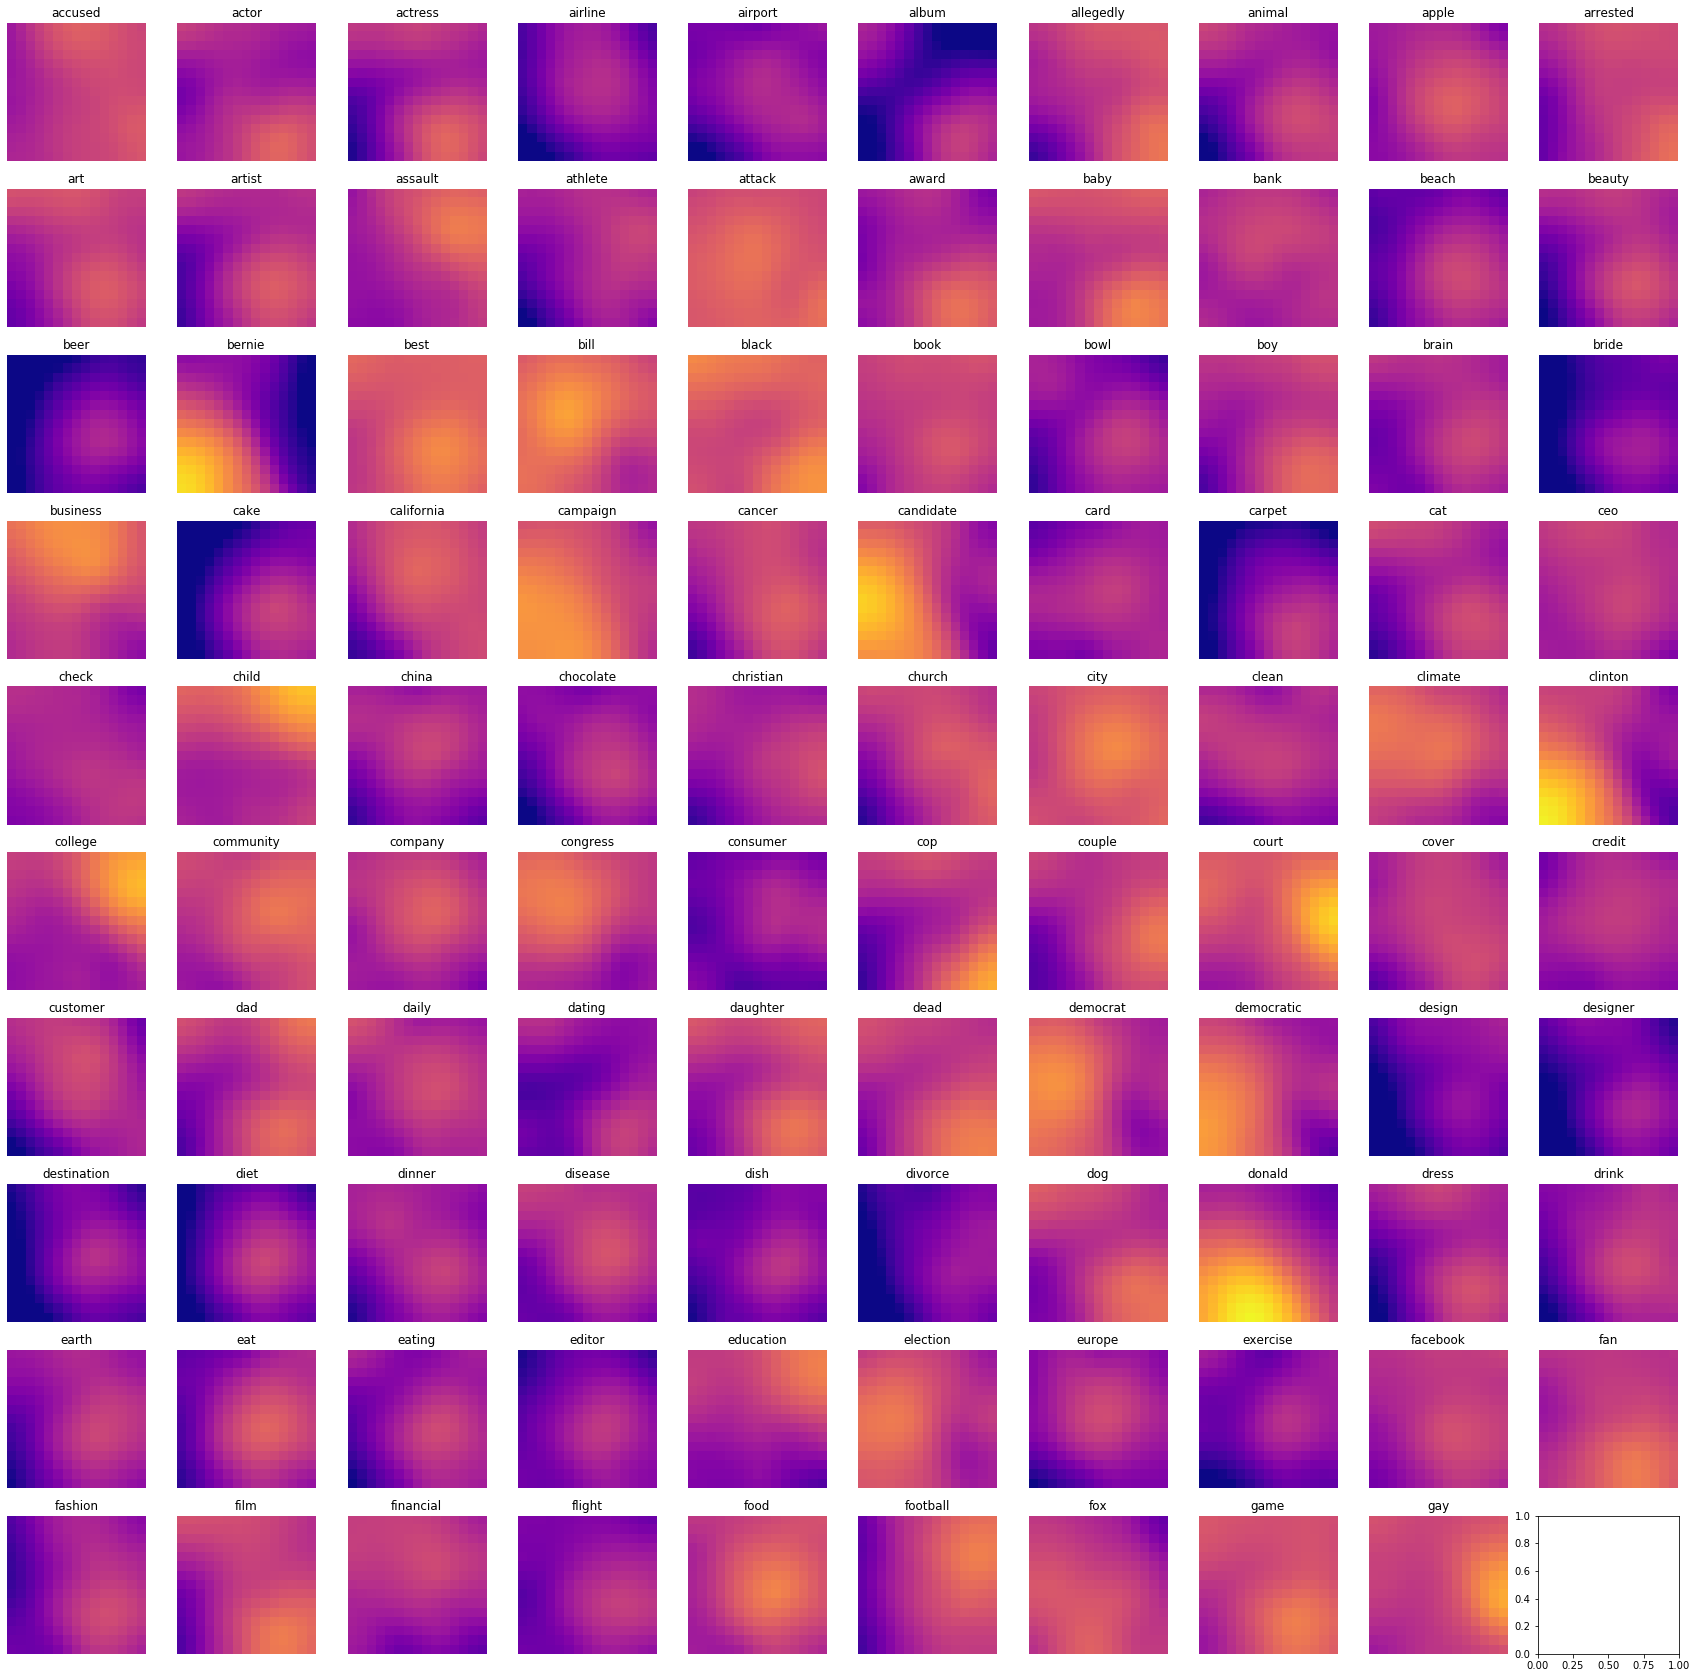

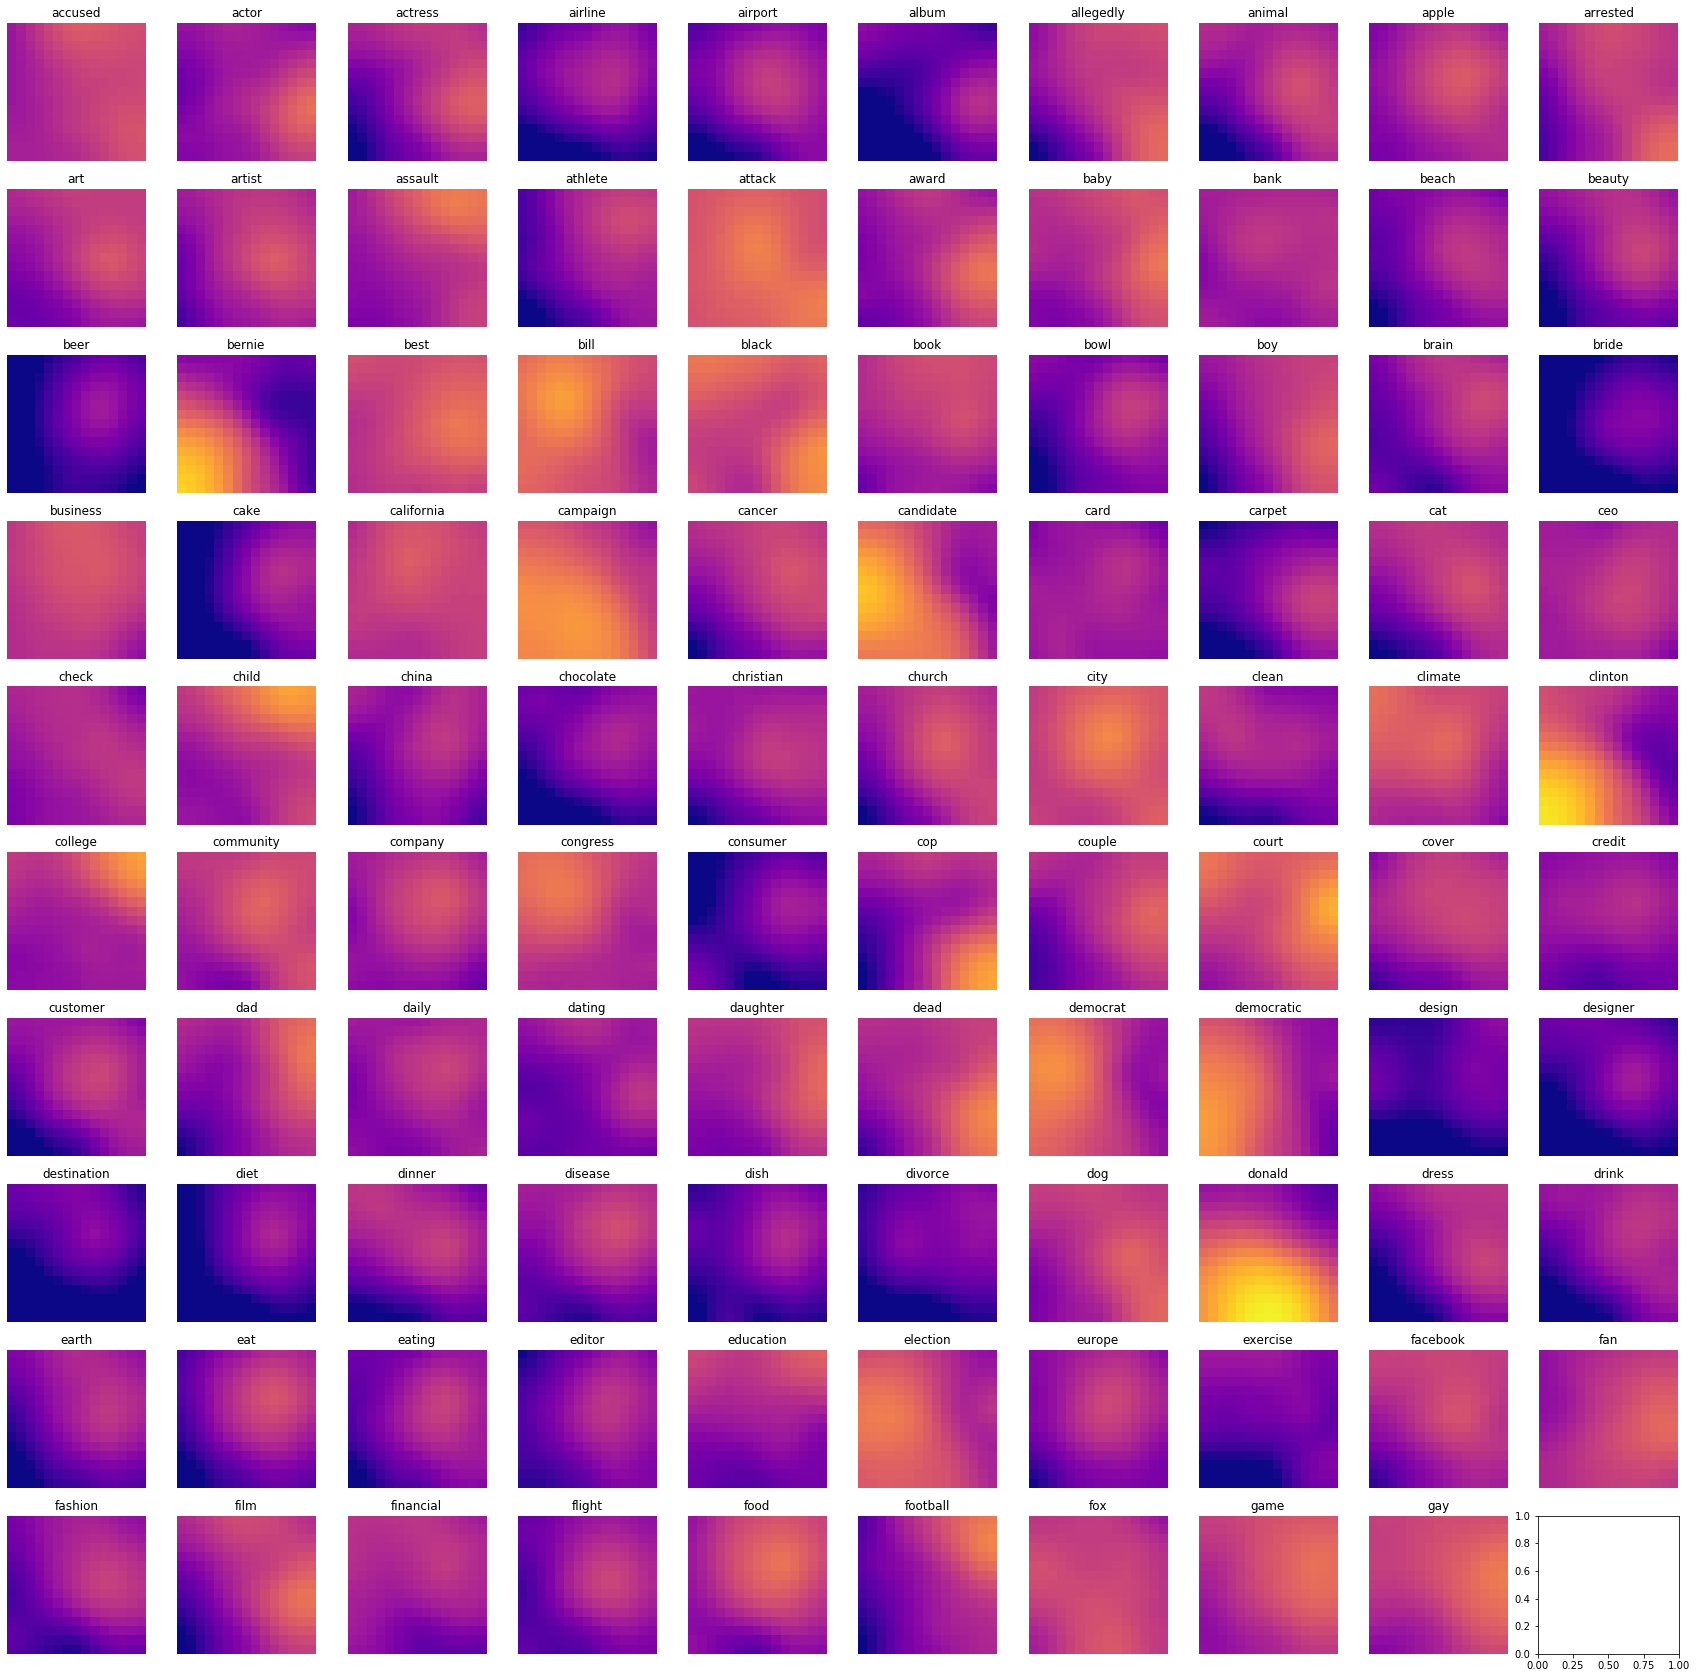

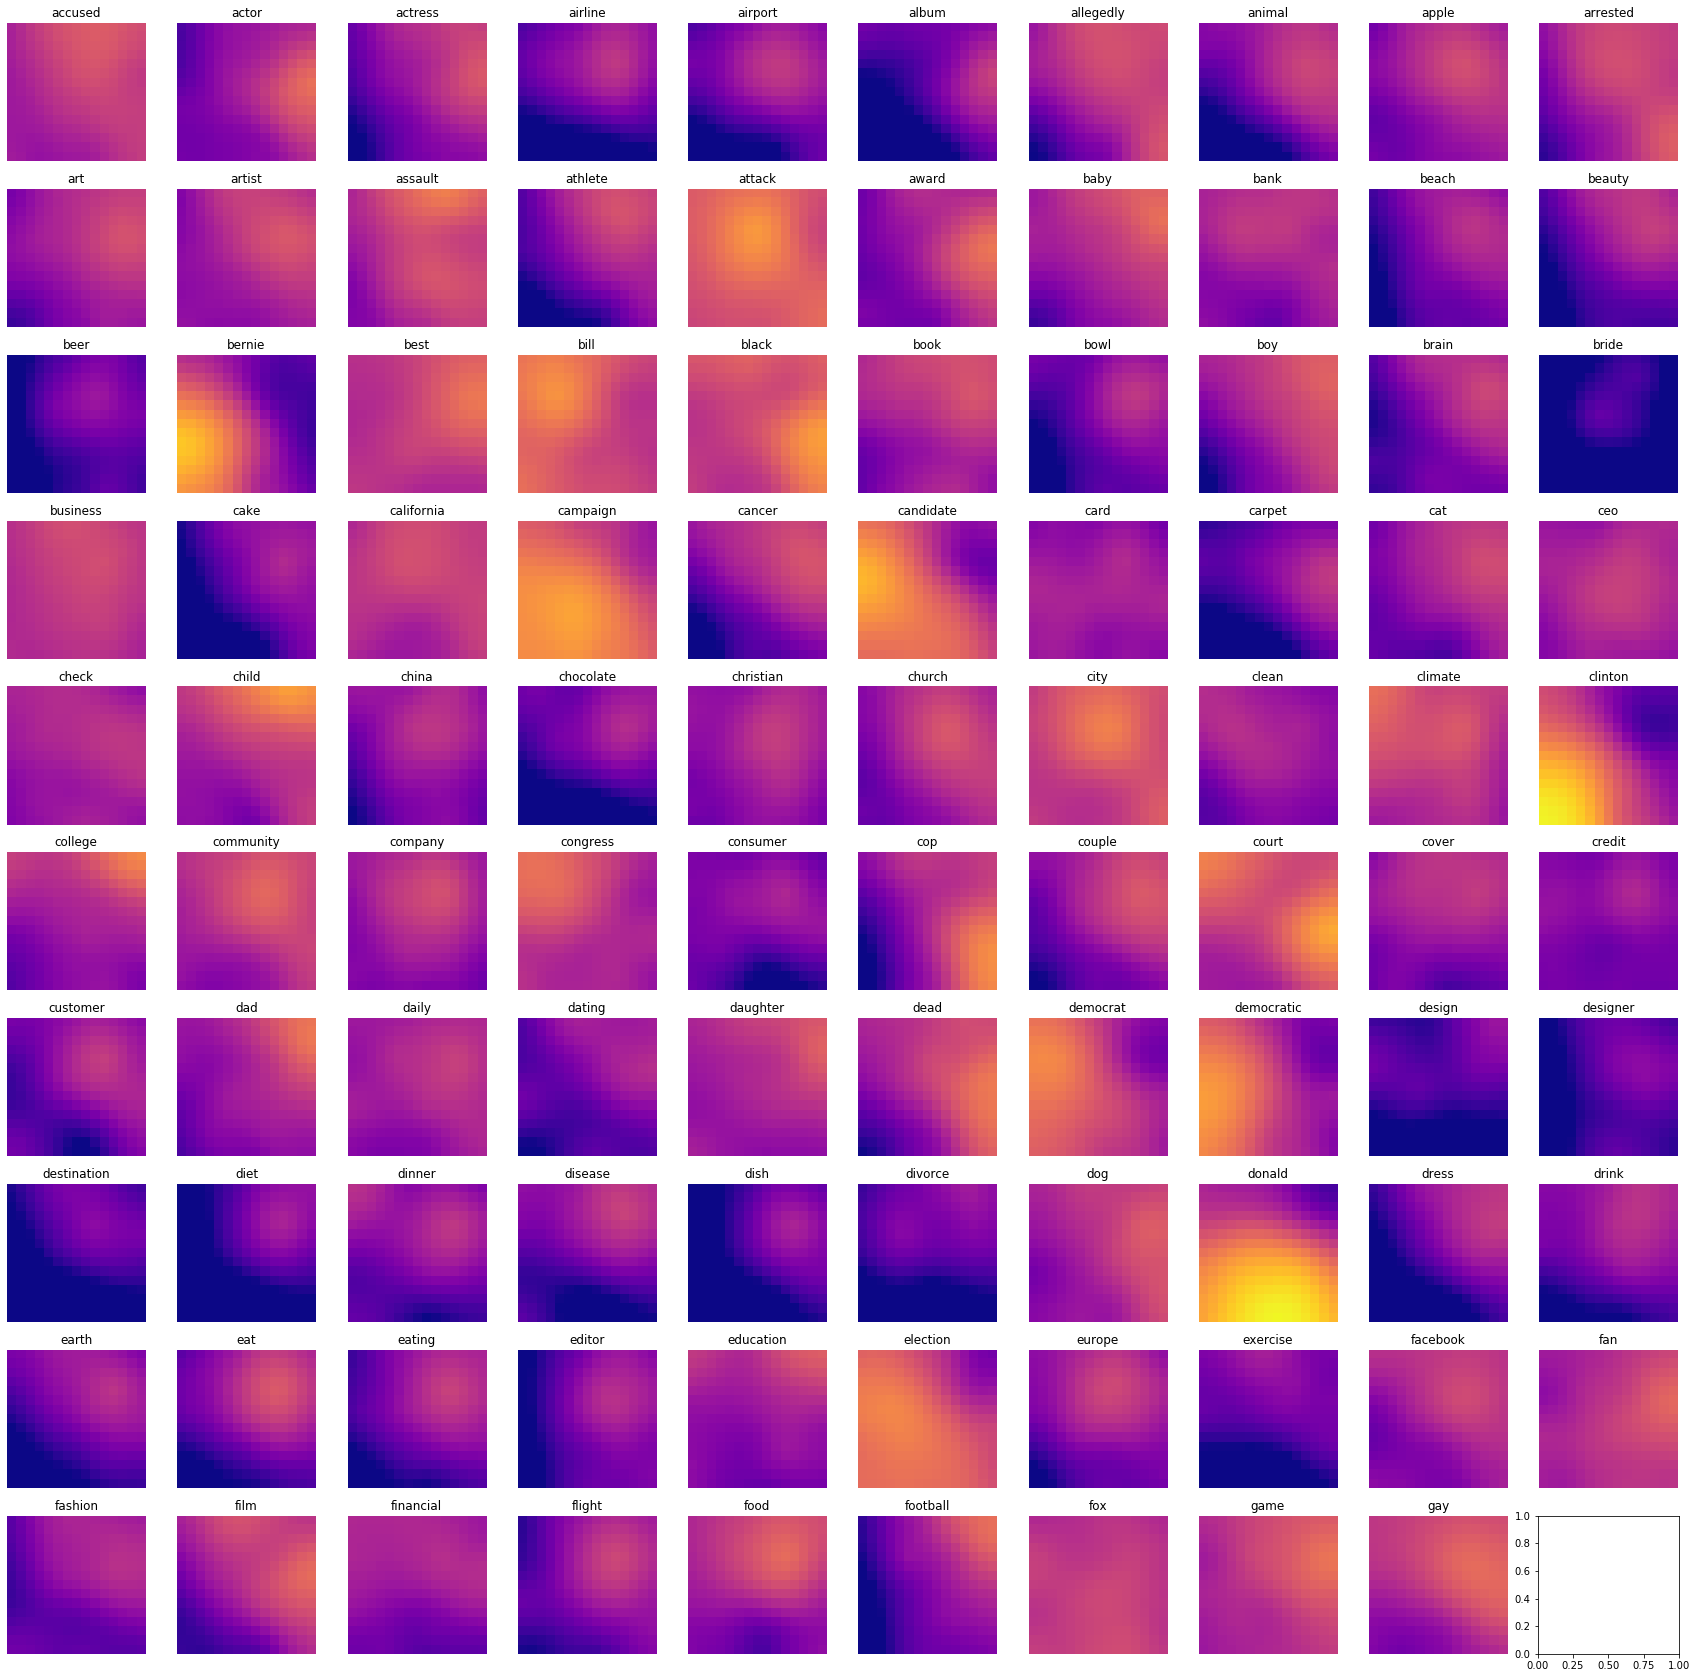

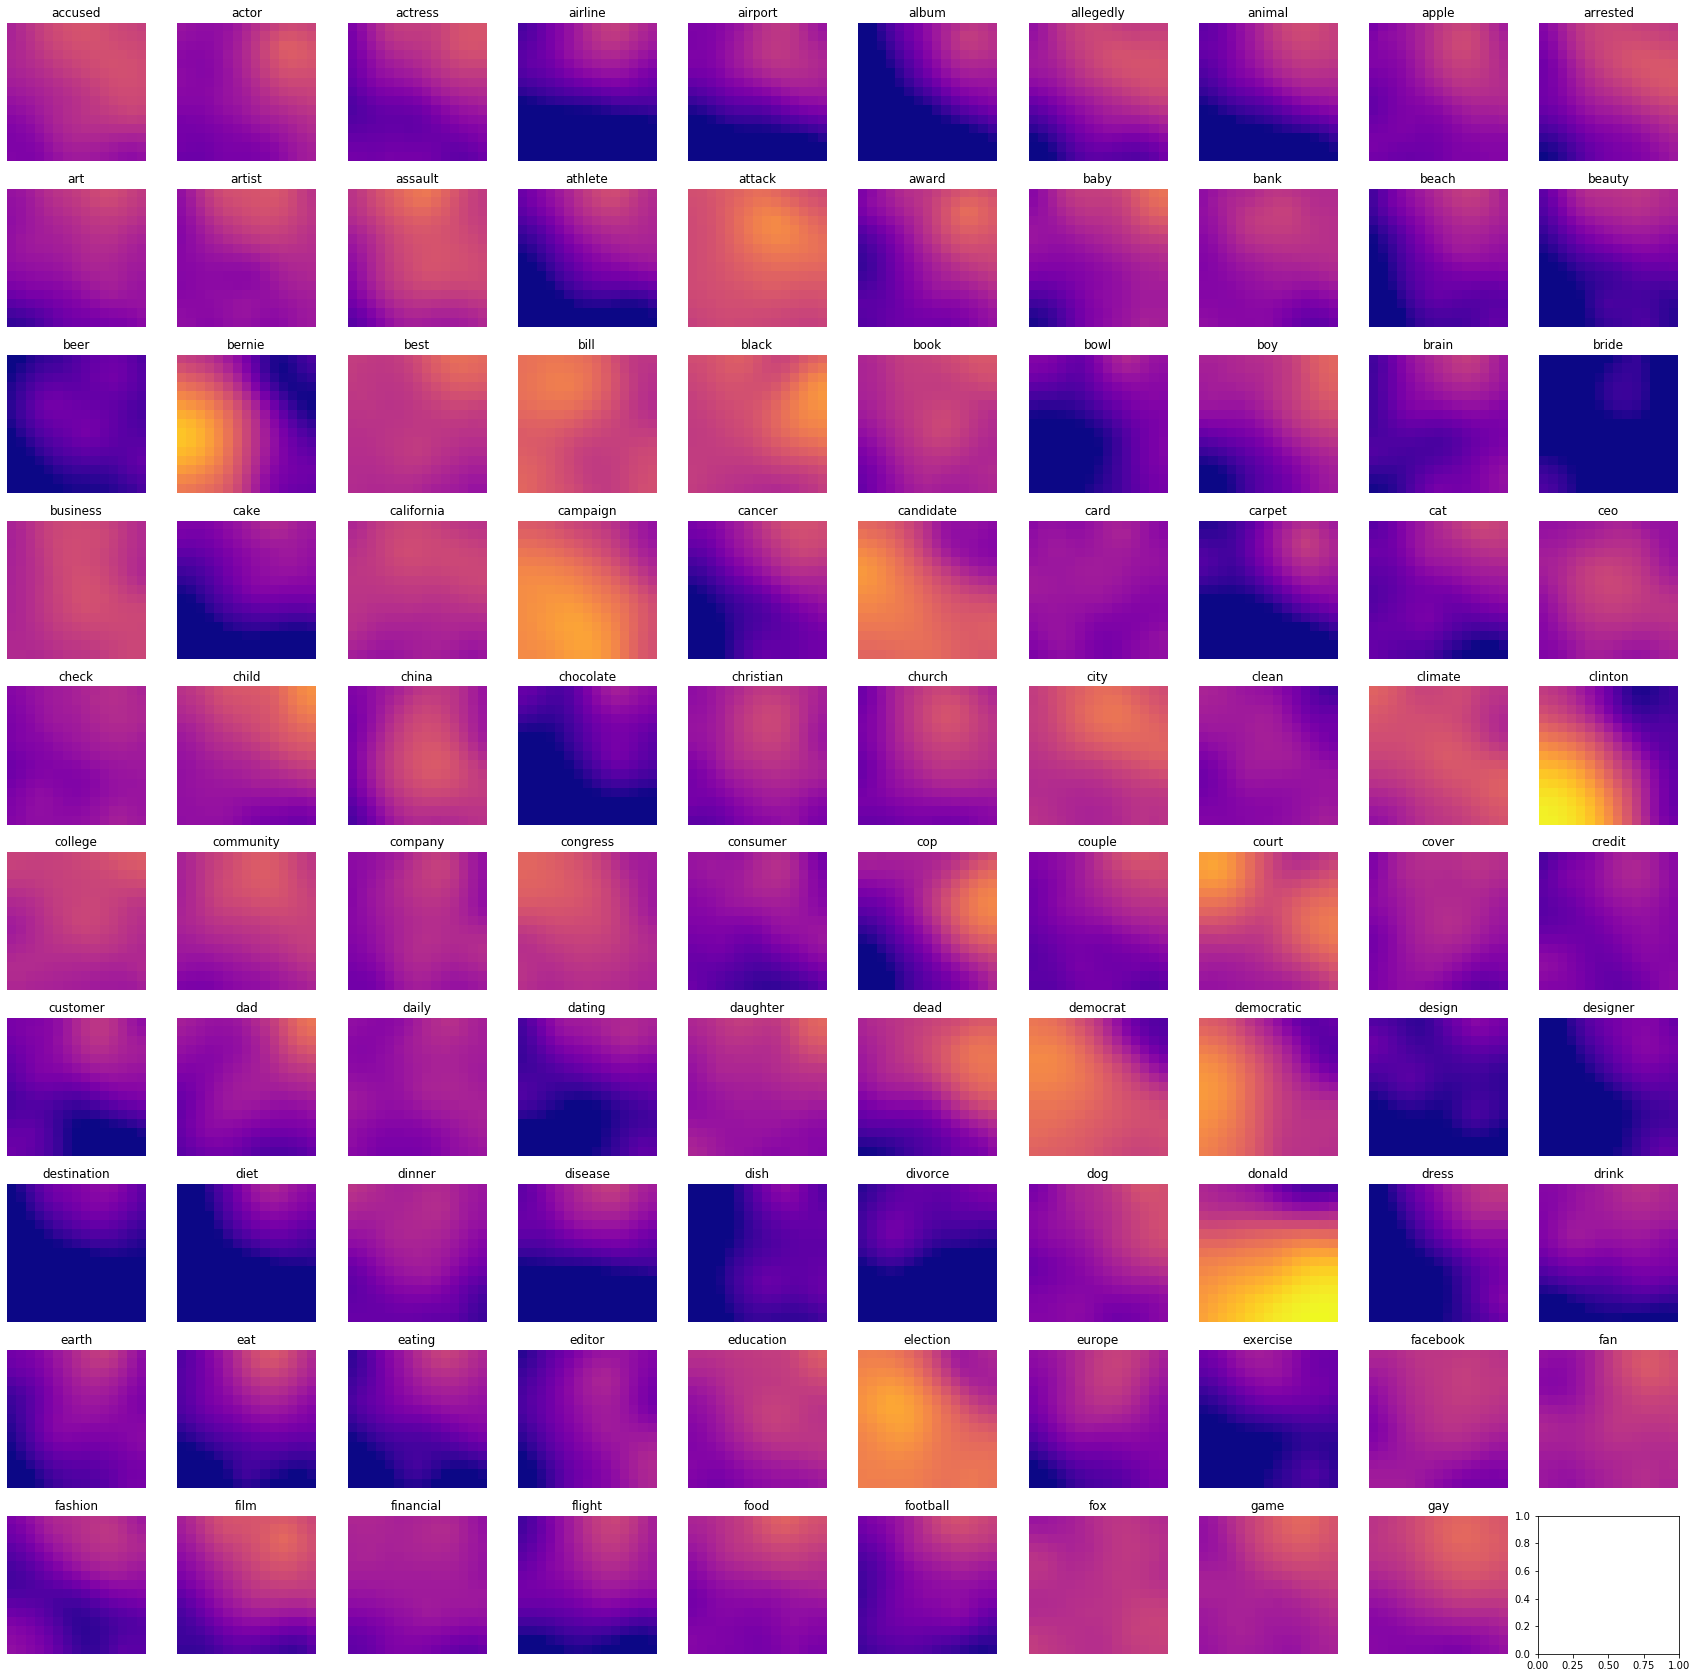

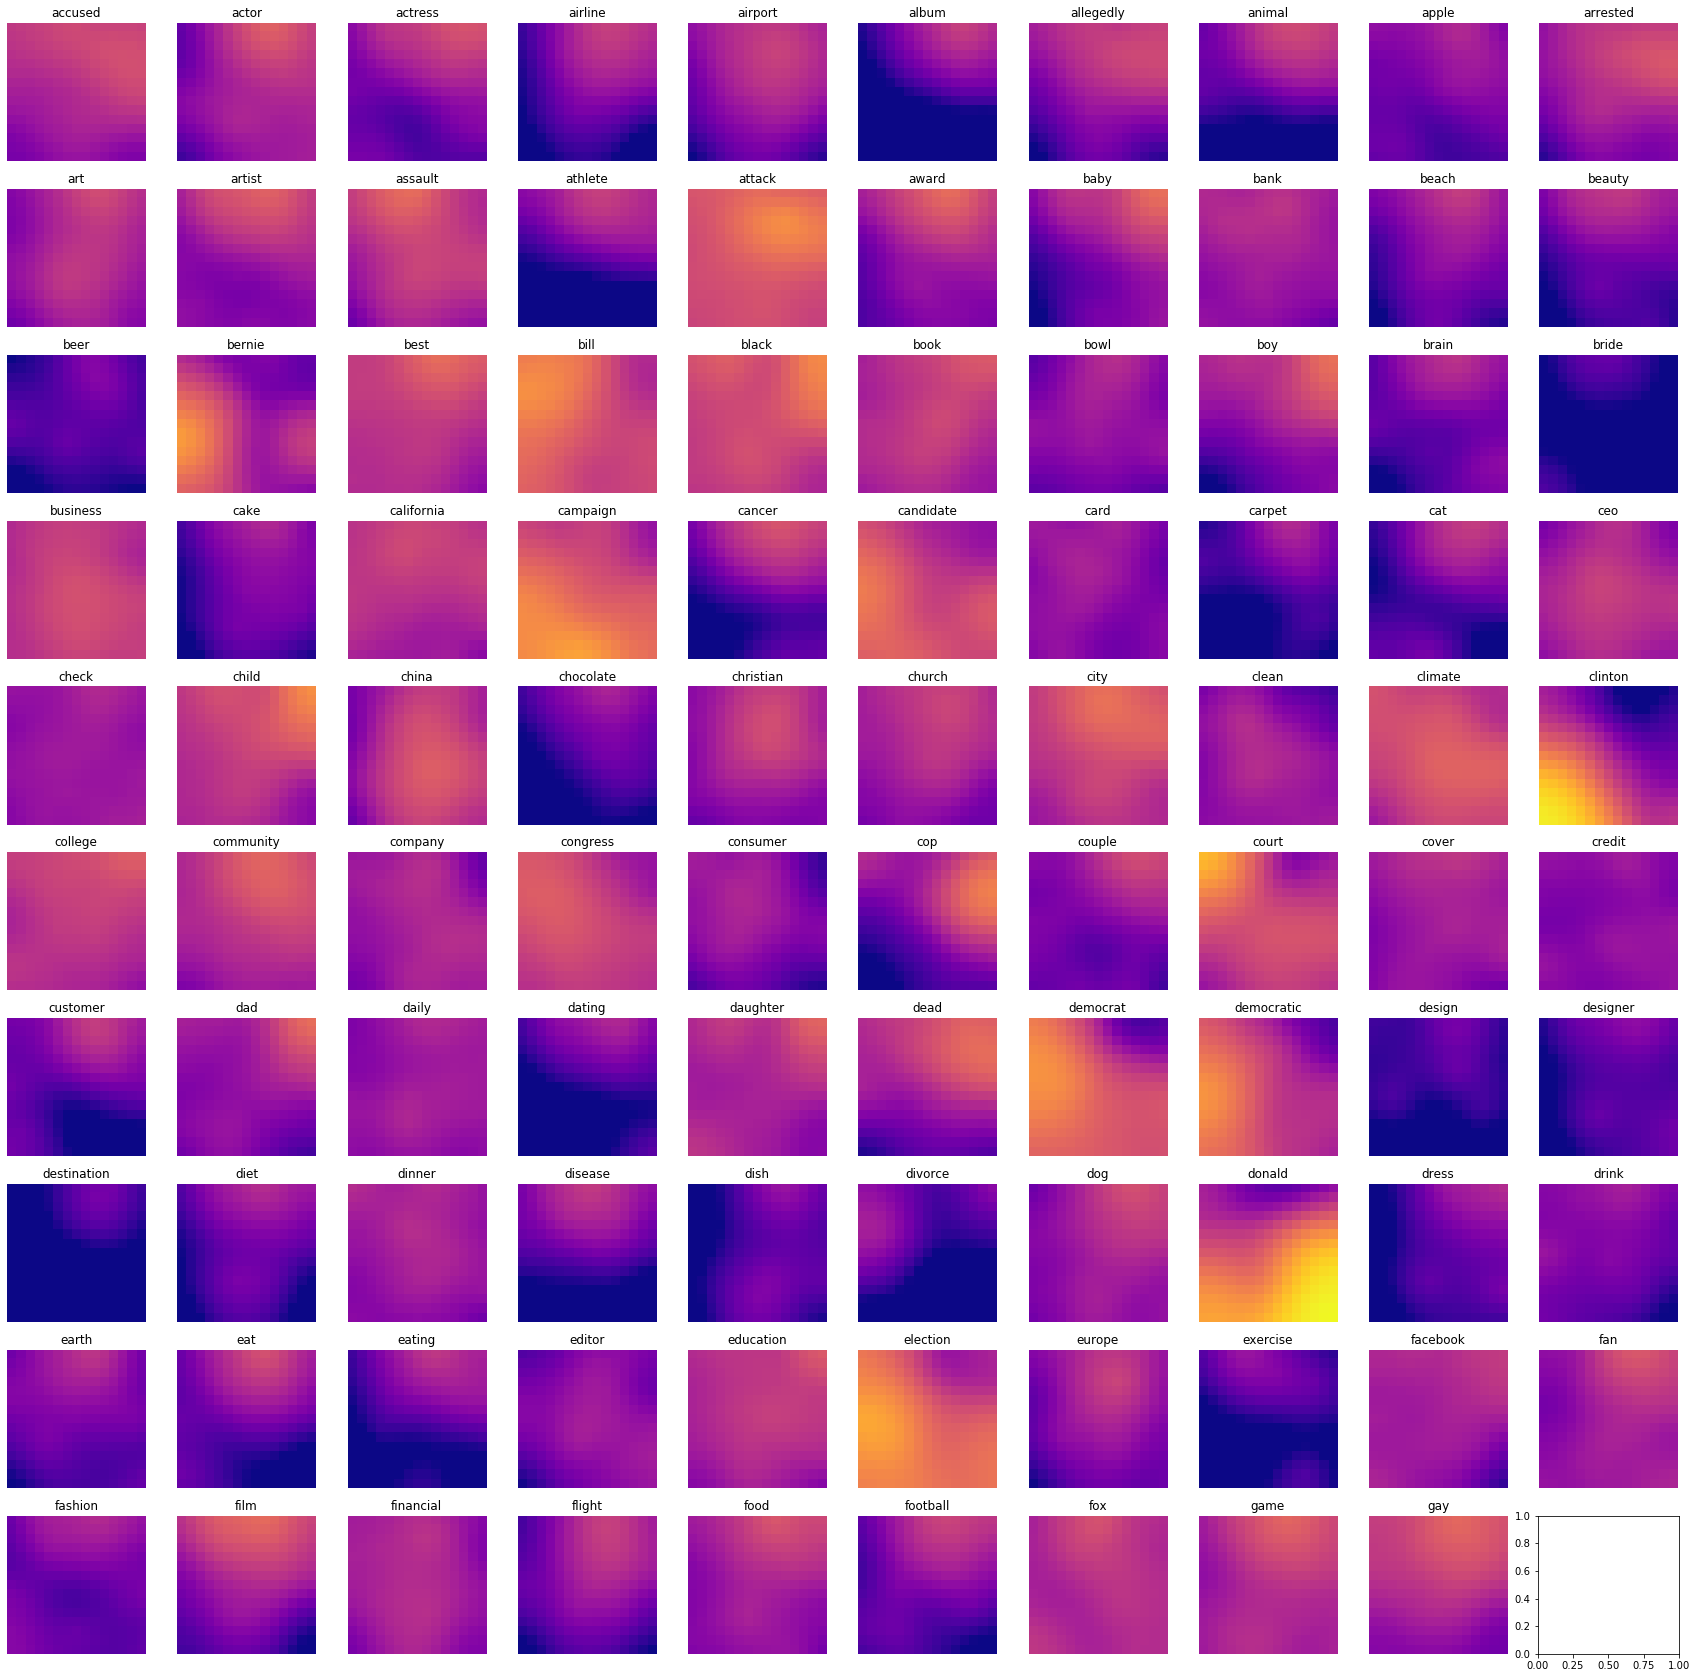

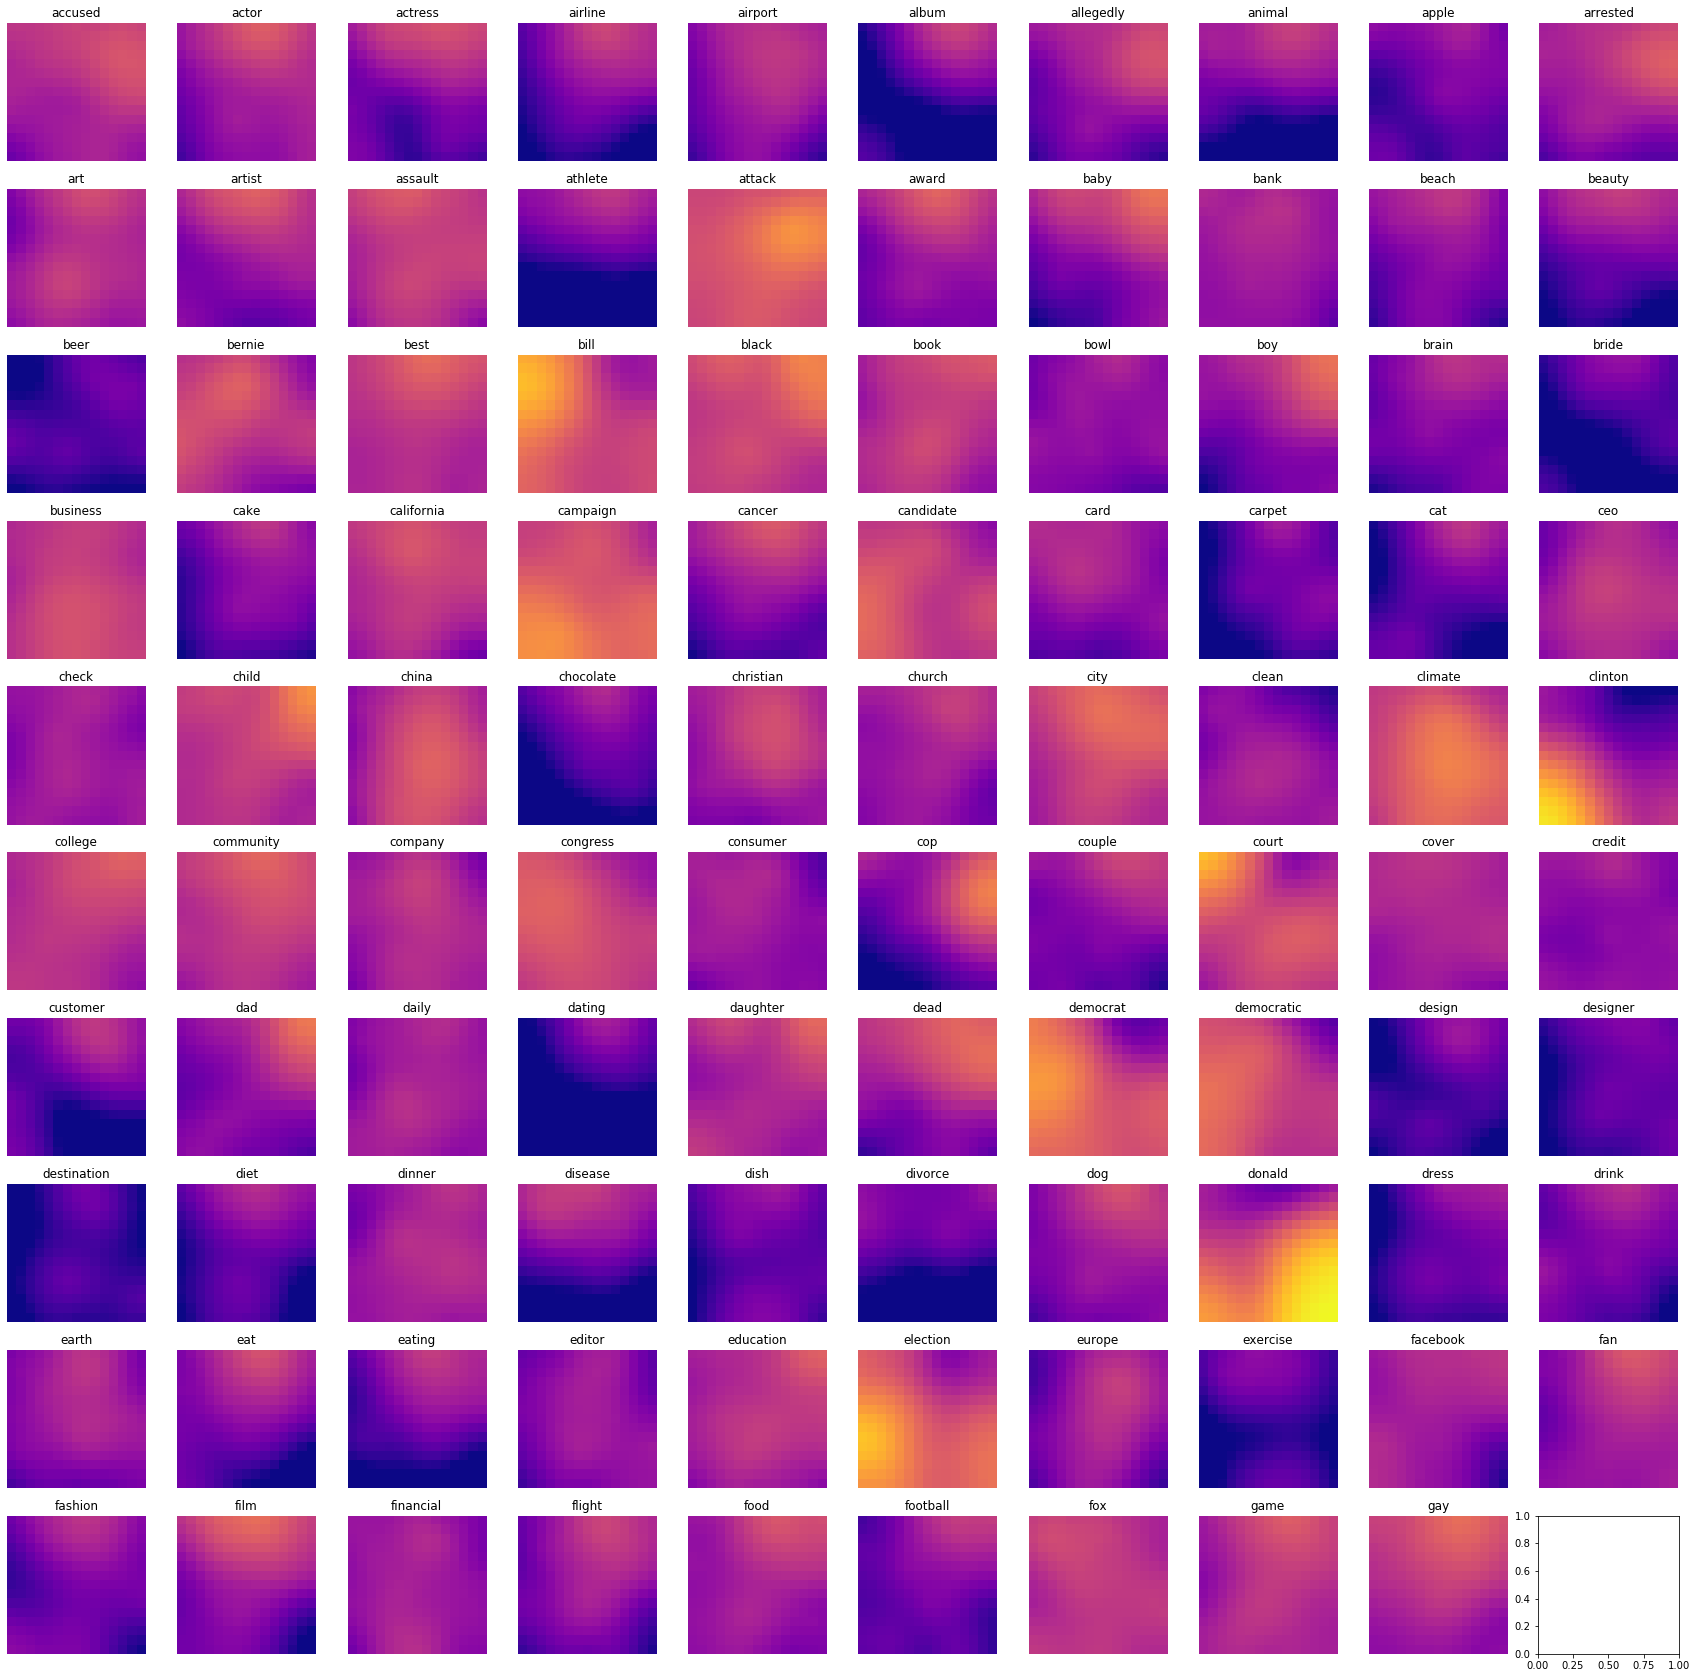

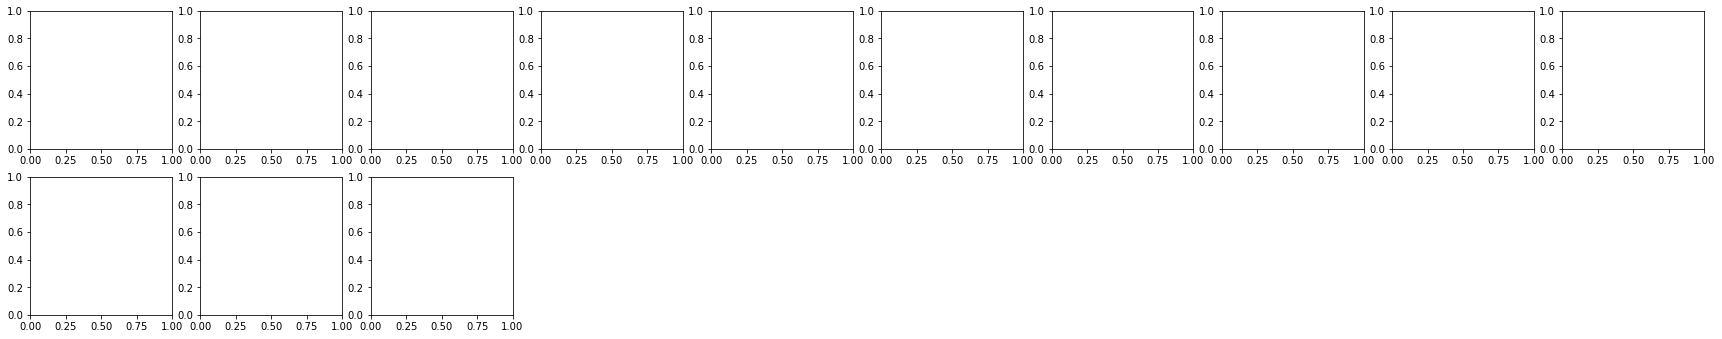

In [21]:
import os 


#############################################################################
maps_path = 'trained_maps/'
visualistions_output = 'trained_maps/'
#############################################################################

# Find all maps (identify that by checking the file format)
map_fns = [f for f in os.listdir(maps_path) if f.split('.')[-1] == 'csv']

# Iterate over all files, create visualisations
for map_fn in map_fns:
    df_som = pd.read_csv(maps_path+map_fn, index_col='UNIT_ID')

    image_fn = visualistions_output + 'heatmap_for_' + map_fn.split('.')[0] + '.png'

    feature_intensity_plotter(som=df_som, feature_id=range(0,99), 
                              feature_names=feature_names, 
                              output_path=image_fn,
                              dpi=100, logscale=True)
